# TODO

- [ ] Checar importância da significância estatística dos coeficientes da regressão

# Setup

In [1]:
!rm *.csv # Removendo dados anteriores
!rm -R figs # Removendo pasta de figuras
!rm -R tabs # Removendo pasta de tabelas
!mkdir figs # Criando pasta para salvar figuras
!mkdir tabs # Criando pasta para salvar tabelas
!ls

Benchmark.html		SeriesTemporais.Rproj	VECM_Infla.pdf
Benchmark.ipynb		tabs			VECM_Infla.py
Benchmark.pdf		tese_Lucas.xls		VECM_TxPropria.html
Benchmark.Rmd		Teste.ipynb		VECM_TxPropria.ipynb
Clean-checkpoint.ipynb	VECM_Infla.html		VECM_TxPropria_media.ipynb
Clean.ipynb		VECM_Infla.ipynb	VECM_TxPropria.pdf
figs			VECM_Infla_media.ipynb	VECM_TxPropria.py


# Introdução

Esta rotina ajusta um modelo de séries temporais. 
Será testado se o investimento residencial ($I_h$) depende da <u>taxa própria de juros</u> dos imóveis, ou seja,

$$
I_h = f(r_{mo}, p_h)
$$
em que

- $I_h$ Investimento residencial

  + **Série:** PRFI
  + Com ajuste sazonal
  + Trimestral
  
- $r_{mo}$ taxa de juros das hipotecas
  + **Série:** MORTGAGE30US
  - Sem ajuste sazonal
  - Semanal (encerrado às quintas feiras)

- $p_h$ Inflação de imóveis: Índice Case-Shiller

  + **Série:** CSUSHPISA
  + Com ajuste sazonal, Jan 2000 = 100
  + Mensal
  
**Nota:** Uma vez que pretende-se utilizar os resultados obtidos deste modelo em um trabalho futuro, os resultados serão checados tanto em python quanto em gretl, ambos softwares livres.

# Carregando pacotes

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext rpy2.ipython

# Pacotes gerais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')
# Pacotes estatísticos

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.api import SVAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, CointRankResults, VECM, select_coint_rank

from statsmodels.stats.diagnostic import acorr_breusch_godfrey, acorr_ljungbox, het_arch, het_breuschpagan, het_white
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests, q_stat, coint
from arch.unitroot import PhillipsPerron, ZivotAndrews, DFGLS, KPSS, ADF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Pacotes para importação de dados

import pandas_datareader.data as web
from scipy.stats import yeojohnson

# Configurações do notebook

plt.style.use('seaborn-white')
start = datetime.datetime(1987, 1, 1)
#start = datetime.datetime(1990, 1, 1)
end = datetime.datetime(2019, 7, 1)

# Importando dados

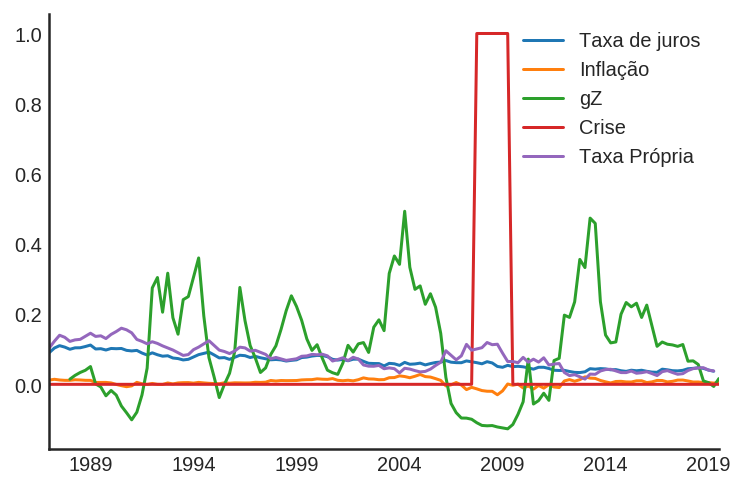

,Taxa de juros,Inflação,gZ,Crise,Taxa Própria,d_Taxa Própria,d_gZ,d_Inflação,d_Taxa de juros
,,,,,,,,,
1988-06-30,0.1040,0.012974,0.025430,0,0.126657,0.004327,0.010722,0.001635,0.0041
1988-09-30,0.1042,0.012430,0.033724,0,0.128151,0.001494,0.008294,-0.000544,0.0002
1988-12-31,0.1077,0.011398,0.039976,0,0.137036,0.008884,0.006252,-0.001032,0.0035
1989-03-31,0.1119,0.011264,0.050665,0,0.145641,0.008606,0.010689,-0.000134,0.0042
1989-06-30,0.1007,0.005247,0.001108,0,0.136518,-0.009123,-0.049557,-0.006017,-0.0112


In [3]:
df = web.DataReader(
    [
        "PRFI",
        "CSUSHPISA",
        "MORTGAGE30US",
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    "Investimento residencial", 
    "Preço dos imóveis", 
    "Taxa de juros",
]
df.index.name = ""

df['Taxa de juros'] = df['Taxa de juros'].divide(100)
df['Preço dos imóveis'] = df['Preço dos imóveis']/df['Preço dos imóveis'][0]
df["Inflação"] = df["Preço dos imóveis"].pct_change(12) # Warning: 12
#df = df.resample('Q').mean() #### Antigo
df = df.resample('Q').last()

df["Taxa Própria"] = ((1+df["Taxa de juros"])/(1+df["Inflação"])) -1
df['Taxa Própria'], *_ = yeojohnson(df['Taxa Própria'])

df['gZ'], *_ = yeojohnson(df["Investimento residencial"].pct_change(4))

df["Crise"] = [0 for i in range(len(df["gZ"]))]
for i in range(len(df["Crise"])):
    if df.index[i] > datetime.datetime(2007,12,1) and df.index[i] < datetime.datetime(2009,7,1):
        df["Crise"][i] = 1

df.to_csv("Dados_yeojohnson.csv")


df.to_csv(
    "Dados_yeojohnson_ascii.csv", 
    encoding='ascii', 
    header = [
        #'data',
        'invRes',
        'preco',
        'juros',
        'infla',
        'taxap',
        'gz',
        'crise',
          ], 
         )

df = df[["Taxa de juros", "Inflação", "gZ", "Crise", "Taxa Própria"]]
df.plot()
sns.despine()
plt.show()

df["d_Taxa Própria"] = df["Taxa Própria"].diff()
df["d_gZ"] = df["gZ"].diff()
df["d_Inflação"] = df["Inflação"].diff()
df["d_Taxa de juros"] = df['Taxa de juros'].diff()
df = df.dropna()
df.head()

# Funções

## Teste de raíz unitária

In [4]:
def testes_raiz(df=df["gZ"], original_trend='c', diff_trend='c'):
    """
    serie: Nome da coluna do df
    orignal_trend: 'c', 'ct', 'ctt'
    diff_trend: 'c', 'ct', 'ctt'
    
    Plota série o original e em diferenta e retorna testes de raíz unitária
    """
    fig, ax = plt.subplots(1,2)

    df.plot(ax=ax[0], title='série original')
    df.diff().plot(ax=ax[1], title='série em diferença')

    plt.tight_layout()
    sns.despine()
    plt.show()
    
    fig, ax = plt.subplots(2,2)
    
    plot_acf(df, ax=ax[0,0], title='ACF: serie original') 
    plot_pacf(df, ax=ax[0,1], title='PACF: serie original')
    
    plot_acf(df.diff().dropna(), ax=ax[1,0], title='ACF: serie em diferença') 
    plot_pacf(df.diff().dropna(), ax=ax[1,1], title='PACF: serie em diferença')
    
    plt.tight_layout()
    sns.despine() 
    plt.show()

    
    # Zivot Andrews
    print('\nZIVOT ANDREWS série em nível')
    print(ZivotAndrews(df, trend = original_trend).summary(),"\n")
    print('\nZIVOT ANDREWS série em primeira difenrença')
    print(ZivotAndrews(df.diff().dropna(), trend = diff_trend).summary(),"\n")
    
    print('\nADF série em nível')
    print(ADF(df, trend=original_trend).summary(),"\n")
    print('\nADF série em primeira diferença')
    print(ADF(df.diff().dropna(), trend=diff_trend).summary(),"\n")
    
    print('\nDFGLS série em nível')
    print(DFGLS(df, trend=original_trend).summary(),"\n")
    print('\nDFGLS série em primeira diferença')
    print(DFGLS(df.diff().dropna(), trend=diff_trend).summary(),"\n")
    
    print('\nKPSS em nível')
    print(KPSS(df, trend = original_trend).summary(),"\n")
    print('\nKPSS em primeira diferença')
    print(KPSS(df.diff().dropna(), trend = diff_trend).summary(),"\n")
    
    print('\nPhillips Perron em nível')
    print(PhillipsPerron(df, trend=original_trend).summary(),"\n")
    print('\nPhillips Perron em primeira diferença')
    print(PhillipsPerron(df.diff().dropna(), trend=diff_trend).summary(),"\n")

## Teste de Cointegração Engel-Granger e de Johansen

In [5]:
# Teste de cointegração

def cointegracao(ts0, ts1, signif = 0.05, lag=1):
  trends = ['nc', 'c', 'ct', 'ctt']
  for trend in trends:
    print(f"\nTestando para lag = {lag} e trend = {trend}")
    result = coint(ts0, ts1, trend = trend, maxlag=lag)
    print('Null Hypothesis: there is NO cointegration')
    print('Alternative Hypothesis: there IS cointegration')
    print('t Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] < signif:
      print('CONCLUSION: REJECT null Hypothesis: there IS cointegration\n')
    else:
      print('CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration\n')
    
def testes_coint(series, maxlag=8):
    for i in range(1, maxlag):
        print(50*'=')
        cointegracao(
            ts0=series.iloc[:, 0],
            ts1=series.iloc[:, 1:],
            signif=0.05,
            lag=i
        )
        print("\nTESTE DE JOHANSEN\n")
        result = select_coint_rank(endog=series, k_ar_diff=i, det_order=1) ## Warning: 1
        print(result.summary())
        print(f'Para lag = {i}, Rank = {result.rank}')
        print(10*'=')

## Análise de resíduos: Ljung-Box e Box-Pierce

In [6]:
### Resíduos

def LjungBox_Pierce(resid, signif = 0.05, boxpierce = False, k = 4):
  """
  resid = residuals df
  signif = signif. level
  """
  var = len(resid.columns)
  print("H0: autocorrelations up to lag k equal zero")
  print('H1: autocorrelations up to lag k not zero')
  print("Box-Pierce: ", boxpierce)
  
  for i in range(var):
    print("Testing for ", resid.columns[i].upper(), ". Considering a significance level of",  signif*100,"%")
    result = acorr_ljungbox(x = resid.iloc[:,i-1], lags = k, boxpierce = boxpierce)[i-1] < signif
    for j in range(k):
      print("Reject H0 on lag " ,j+1,"? ", result[j])
    print("\n")
    
def ARCH_LM(resid, signif = 0.05, autolag = 'bic'):
  """
  df = residuals df
  signif = signif. level
  """
  var = len(resid.columns)
  print("H0: Residuals are homoscedastic")
  print('H1: Residuals are heteroskedastic')
  
  for i in range(var):
    print("Testing for ", resid.columns[i].upper())
    result = het_arch(resid = resid.iloc[:,i], autolag = autolag)
    print('LM p-value: ', result[1])
    print("Reject H0? ", result[1] < signif)
    print('F p-value: ', result[3])
    print("Reject H0? ", result[3] < signif)
    print('\n')
    

def analise_residuos(results, nmax=15):
    
    residuals = pd.DataFrame(results.resid, columns = results.names)
    
    residuals.plot()
    sns.despine()
    plt.show()
    
    for serie in residuals.columns:
        sns.set_context('paper')
        fig, ax = plt.subplots(1,2, figsize=(10,8))

        plot_acf(residuals[serie], ax=ax[0], title=f'ACF Resíduo de {serie}', zero=False) 
        plot_pacf(residuals[serie], ax=ax[1], title=f'PACF Resíduo de {serie}', zero=False)
        
        plt.tight_layout()
        sns.despine() 
        plt.show()

    print('AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU\n')
    print(results.test_whiteness(nlags=nmax).summary())
    print('\nAUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO\n')
    print(results.test_whiteness(nlags=nmax, adjusted=True).summary())
    print('\nLJUNGBOX\n')
    LjungBox_Pierce(residuals, k = 12, boxpierce=False)
    print('\nBOXPIERCE\n')
    LjungBox_Pierce(residuals, k = 12, boxpierce=True)
    print('\nNORMALIDADE\n')
    print(results.test_normality().summary())
    print('\nHOMOCEDASTICIDADE\n')
    ARCH_LM(residuals)
    
    return residuals
    

In [7]:
results = []
def plot_lags(results = results, trimestres=[2, 5]):
    series = results.names
    fig, ax = plt.subplots(len(trimestres),2, figsize = (16,10))
    
    for i in range(len(trimestres)):
        sns.regplot(y = df[series[0]], x = df[series[1]].shift(-trimestres[i]), color = 'black', ax = ax[i,0], order = 2)
        ax[i,0].set_xlabel(f'{series[1]} defasada em {trimestres[i]} trimestres')

        sns.regplot(x = df[series[0]].shift(-trimestres[i]), y = df[series[1]], color = 'black', ax = ax[i,1], order = 2)
        ax[i,1].set_xlabel(f'{series[0]} defasada em {trimestres[i]} trimestres')

# Teste de quebra estrutural

In [8]:
%%R -i df
library(strucchange)
library(urca)
df <- df[,c(4:7)]
names(df) <- c("Juros", "Infla", "TaxaP", "gZ")
df <- ts(data = df, start = c(1987,01), frequency = 4)
bp_ts <- breakpoints(Juros ~ 1, data=df)
print("Testando quebra estrutural para Taxa de juros das hipotecas")
print(summary(bp_ts))

bp_ts <- breakpoints(gZ ~ 1, data=df)
print("=========================")
print("Testando quebra estrutural para Taxa de crescimento dos imóveis")
print(summary(bp_ts))

bp_ts <- breakpoints(TaxaP ~ 1, data=df)
print("=========================")
print("Testando quebra estrutural para Taxa Própria")
print(summary(bp_ts))

bp_ts <- breakpoints(Infla ~ 1, data=df)
print("=========================")
print("Testando quebra estrutural para Inflação")
print(summary(bp_ts))

R[write to console]: Carregando pacotes exigidos: zoo

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


R[write to console]: Carregando pacotes exigidos: sandwich



[1] "Testando quebra estrutural para Taxa de juros das hipotecas"

	 Optimal (m+1)-segment partition: 

Call:
breakpoints.formula(formula = Juros ~ 1, data = df)

Breakpoints at observation number:
                      
m = 1            78   
m = 2            67 85
m = 3   18       67 85
m = 4   18 36    67 85
m = 5   18 36 54 73 91

Corresponding to breakdates:
                                               
m = 1                           2006(2)        
m = 2                           2003(3) 2008(1)
m = 3   1991(2)                 2003(3) 2008(1)
m = 4   1991(2) 1995(4)         2003(3) 2008(1)
m = 5   1991(2) 1995(4) 2000(2) 2005(1) 2009(3)

Fit:
                                                   
m   0       1       2       3       4       5      
RSS   6.608   5.957   4.278   4.278   4.278   4.278
BIC  -3.113  -6.411 -38.155 -28.499 -18.842  -9.186
[1] "========================="
[1] "Testando quebra estrutural para Taxa de crescimento dos imÃ³veis"

	 Optimal (m+1)-segment part

Selecionando série para depois de 1991

In [9]:
df = df["1992-01-01":]

# Teste de raíz unitária

## Investimento residencial ($g_Z$)

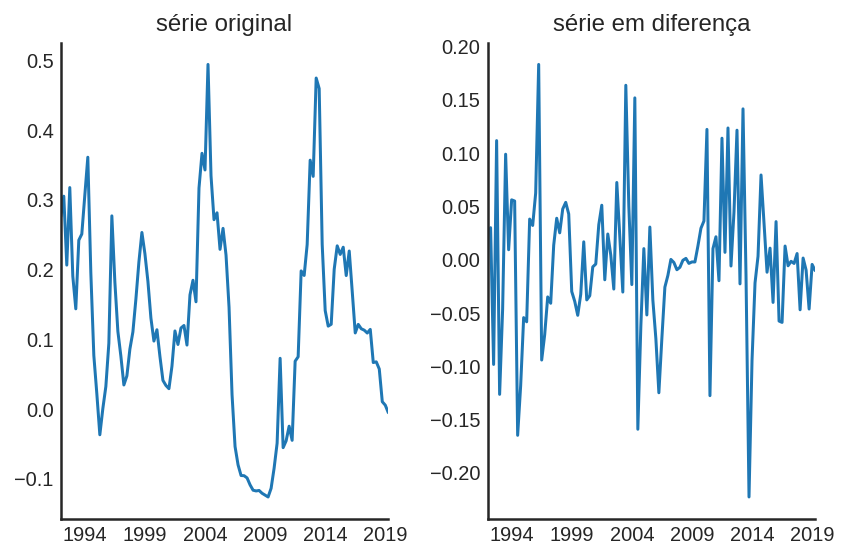

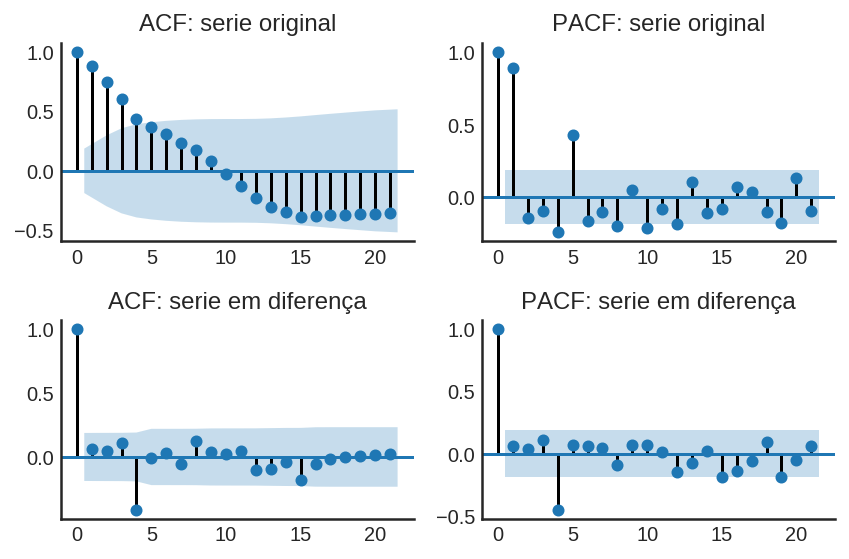


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -3.206
P-value                         0.838
Lags                                5
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                 -7.727
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.406
P-value 

In [10]:
testes_raiz(df=df['gZ'])

**Conclusão:** Série  não é fracamente estacionária.

## Taxa própria

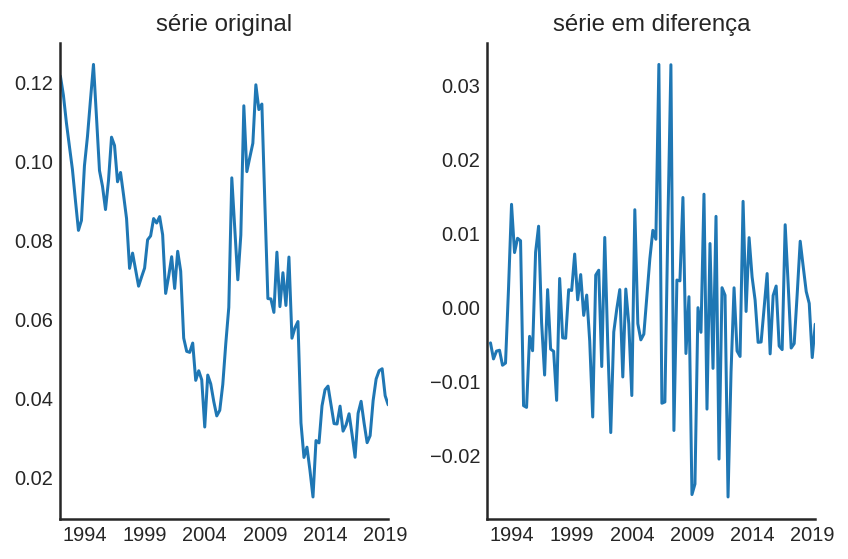

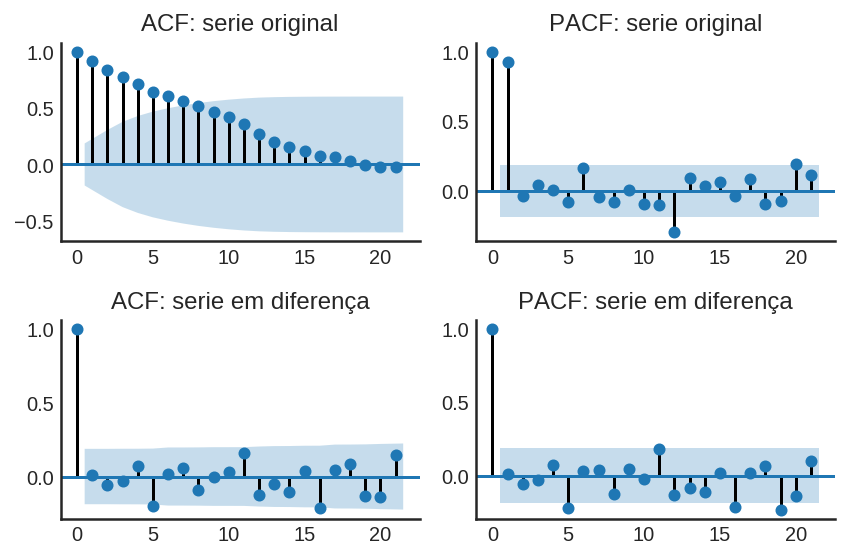


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -4.103
P-value                         0.291
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                -10.686
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.212
P-value 

In [11]:
testes_raiz(df['Taxa Própria'])

**Conclusão:** Será tomada em primeira diferença.

## Inflação

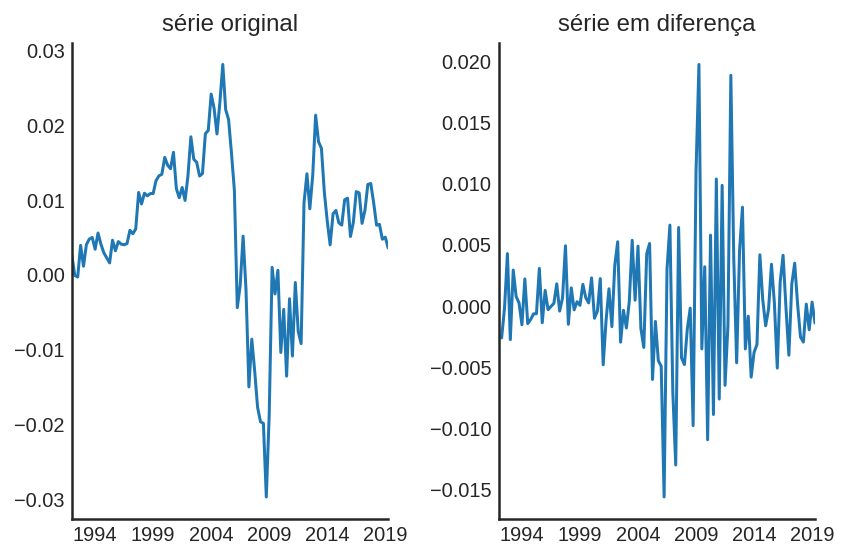

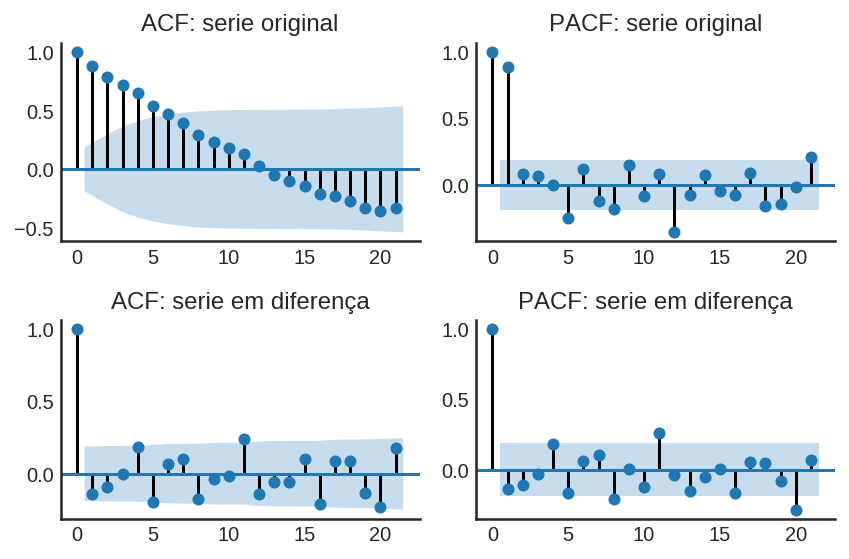


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -4.891
P-value                         0.041
Lags                               11
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                -12.705
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.665
P-value 

In [12]:
testes_raiz(df['Inflação'])

## Taxa de juros das hipotecas

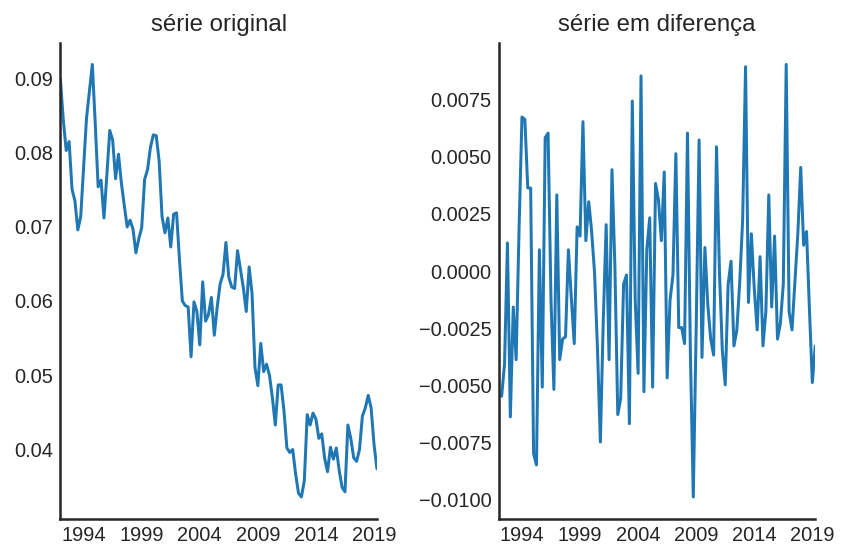

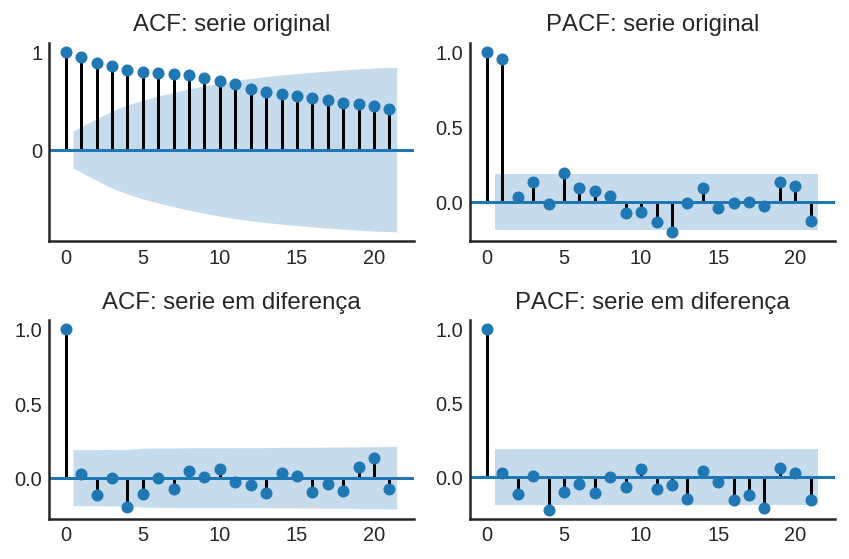


ZIVOT ANDREWS série em nível
        Zivot-Andrews Results        
Test Statistic                 -4.494
P-value                         0.215
Lags                                0
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -5.58 (1%), -5.07 (5%), -4.83 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS série em primeira difenrença
        Zivot-Andrews Results        
Test Statistic                 -8.144
P-value                         0.000
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF série em nível
   Augmented Dickey-Fuller Results   
Test Statistic          

In [13]:
testes_raiz(df['Taxa de juros'], original_trend='ct')

# Cointegração

## $g_Z$ e Taxa Própria

In [14]:
print("Ordem do VAR\n")

model = VAR(
    df[["gZ", 'Taxa Própria']],
)
print(model.select_order(maxlags=15, trend='ct').summary())

Ordem do VAR

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -12.60      -12.49   3.382e-06      -12.55
1       -14.97     -14.75*   3.162e-07     -14.88*
2       -14.95      -14.62   3.230e-07      -14.82
3       -14.91      -14.48   3.366e-07      -14.73
4       -14.95      -14.41   3.227e-07      -14.73
5       -15.03      -14.38   2.981e-07      -14.77
6      -15.04*      -14.29  2.938e-07*      -14.74
7       -15.02      -14.16   3.030e-07      -14.67
8       -14.96      -14.00   3.201e-07      -14.57
9       -14.91      -13.84   3.377e-07      -14.48
10      -14.85      -13.67   3.607e-07      -14.37
11      -14.80      -13.51   3.807e-07      -14.28
12      -14.82      -13.42   3.769e-07      -14.26
13      -14.74      -13.24   4.103e-07      -14.13
14      -14.68      -13.07   4.409e-07      -14.03
15      -14.73      -13.01   4.215e-07      -14.04
-----------------

In [15]:
testes_coint(series=df[['gZ', 'Taxa Própria']], maxlag=9)


Testando para lag = 1 e trend = nc
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.587407
p-value: 0.075501
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 1 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.986274
p-value: 0.113504
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 1 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.255430
p-value: 0.000299
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.396836
p-value: 0.000724
CONCLUSION: REJECT null Hypothesis: there IS cointegration


TESTE DE JOHANSEN

Johansen cointegration test using trace test stati

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          20.26          18.40
  1   2          8.557          3.841
-------------------------------------
Para lag = 7, Rank = 2

Testando para lag = 8 e trend = nc
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.467834
p-value: 0.098238
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 8 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.046307
p-value: 0.504439
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 8 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.614543
p-value: 0.076004
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointeg

## $g_Z$, Inflação e taxa de juros

In [16]:
print("Ordem do VAR\n")

model = VAR(
    df[["gZ", 'Inflação', "Taxa de juros"]],
)
print(model.select_order(maxlags=15, trend='ct').summary())

Ordem do VAR

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -24.24      -24.08   2.980e-11      -24.17
1      -27.61*     -27.20*  1.025e-12*     -27.44*
2       -27.60      -26.96   1.031e-12      -27.34
3       -27.45      -26.56   1.203e-12      -27.09
4       -27.41      -26.28   1.252e-12      -26.96
5       -27.44      -26.07   1.229e-12      -26.88
6       -27.38      -25.77   1.307e-12      -26.73
7       -27.31      -25.46   1.419e-12      -26.56
8       -27.25      -25.16   1.522e-12      -26.41
9       -27.19      -24.85   1.653e-12      -26.24
10      -27.07      -24.49   1.893e-12      -26.03
11      -27.13      -24.30   1.845e-12      -25.99
12      -27.20      -24.13   1.777e-12      -25.96
13      -27.16      -23.85   1.923e-12      -25.82
14      -27.19      -23.65   1.947e-12      -25.76
15      -27.18      -23.39   2.093e-12      -25.65
-----------------

In [17]:
testes_coint(series=df[['gZ', 'Inflação', 'Taxa de juros']])


Testando para lag = 1 e trend = nc
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.013702
p-value: 0.006120
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.104295
p-value: 0.018110
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.378409
p-value: 0.000693
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.511844
p-value: 0.001477
CONCLUSION: REJECT null Hypothesis: there IS cointegration


TESTE DE JOHANSEN

Johansen cointegration test using trace test statistic with 5% significa

Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.986450
p-value: 0.437187
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 7 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.977509
p-value: 0.152702
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


TESTE DE JOHANSEN

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   3          32.97          35.01
-------------------------------------
Para lag = 7, Rank = 0


## $g_Z$ e Inflação

In [18]:
print("Ordem do VAR\n")

model = VAR(
    endog=df[["gZ", 'Inflação']],
    exog=df['Taxa de juros']
)
print(model.select_order(maxlags=15, trend='ct').summary())

Ordem do VAR

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -13.96      -13.80   8.643e-07      -13.90
1       -16.20     -15.93*   9.194e-08     -16.09*
2       -16.16      -15.78   9.596e-08      -16.01
3       -16.10      -15.62   1.017e-07      -15.91
4       -16.14      -15.55   9.819e-08      -15.90
5       -16.24      -15.54   8.904e-08      -15.96
6      -16.24*      -15.43  8.890e-08*      -15.92
7       -16.19      -15.27   9.409e-08      -15.82
8       -16.12      -15.10   1.006e-07      -15.71
9       -16.12      -14.99   1.014e-07      -15.66
10      -16.05      -14.81   1.091e-07      -15.55
11      -16.02      -14.68   1.128e-07      -15.48
12      -16.09      -14.64   1.064e-07      -15.50
13      -16.02      -14.46   1.144e-07      -15.39
14      -15.96      -14.29   1.231e-07      -15.29
15      -15.98      -14.20   1.221e-07      -15.26
-----------------

In [19]:
testes_coint(series=df[['gZ', 'Inflação']])


Testando para lag = 1 e trend = nc
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.126271
p-value: 0.000679
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.107310
p-value: 0.005019
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.102942
p-value: 0.020272
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.091155
p-value: 0.058926
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


TESTE DE JOHANSEN

Johansen cointegration test using trace test statistic with 5

Alternative Hypothesis: there IS cointegration
t Statistic: -4.424214
p-value: 0.001627
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 7 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.102942
p-value: 0.020272
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 7 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -4.330084
p-value: 0.030730
CONCLUSION: REJECT null Hypothesis: there IS cointegration


TESTE DE JOHANSEN

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          16.70          18.40
-------------------------------------
Para lag = 7, Rank = 0


# VECM

VECM: $g_Z$, Inflação e Juros exógeno

## Ordem do modelo

In [20]:
from statsmodels.tsa.vector_ar.vecm import select_order

det = 'cili'
#det = 'ci'
order_vec = select_order(
    df[[
        "Inflação", 
        #"Taxa Própria", 
        "gZ"
    ]], 
    exog=df[["Taxa de juros"]],
    maxlags=15, deterministic=det)

with open('./tabs/VECM_lag_order.tex','w') as fh:
    fh.write(order_vec.summary().as_latex_tabular(tile = "Selação ordem do VECM"))

order_vec.summary()

,AIC,BIC,FPE,HQIC
0,-16.14,-15.82*,9.782e-08,-16.01*
1,-16.10,-15.66,1.022e-07,-15.92
2,-16.04,-15.50,1.086e-07,-15.82
3,-16.07,-15.42,1.050e-07,-15.81
4,-16.18*,-15.42,9.462e-08*,-15.87
5,-16.18,-15.31,9.492e-08,-15.83
6,-16.12,-15.15,1.008e-07,-15.73
7,-16.06,-14.97,1.079e-07,-15.62
8,-16.05,-14.86,1.088e-07,-15.57
9,-15.98,-14.68,1.172e-07,-15.46


## Estimação

In [21]:
model = VECM(
    endog = df[[
        "Inflação", 
        #"Taxa Própria", 
        "gZ"
    ]], 
    exog=df[["Taxa de juros"]],
    k_ar_diff=5,
    deterministic=det
)
results = model.fit()

with open('./tabs/VECM_ajuste.tex','w') as fh:
    fh.write(results.summary().as_latex())

## Análise dos resíduos

Det. terms outside the coint. relation & lagged endog. parameters for equation Inflação
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
exog1          -0.1553      0.069     -2.249      0.025      -0.291      -0.020
L1.Inflação    -0.2090      0.103     -2.023      0.043      -0.411      -0.007
L1.gZ           0.0052      0.009      0.580      0.562      -0.012       0.023
L2.Inflação    -0.2208      0.101     -2.180      0.029      -0.419      -0.022
L2.gZ           0.0167      0.008      2.165      0.030       0.002       0.032
L3.Inflação    -0.1356      0.104     -1.303      0.193      -0.340       0.068
L3.gZ           0.0088      0.008      1.152      0.249      -0.006       0.024
L4.Inflação     0.0684      0.100      0.683      0.495      -0.128       0.265
L4.gZ           0.0080      0.007      1.066      0.287      -0.007       0.023
L5.Inflação    -0.2508      0.09

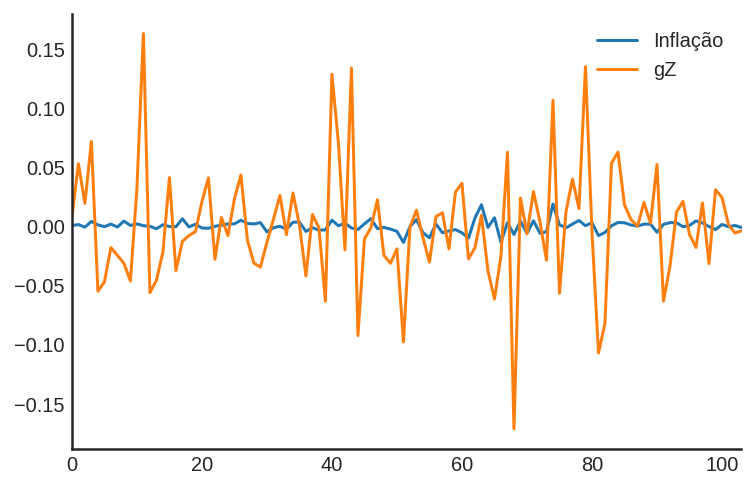

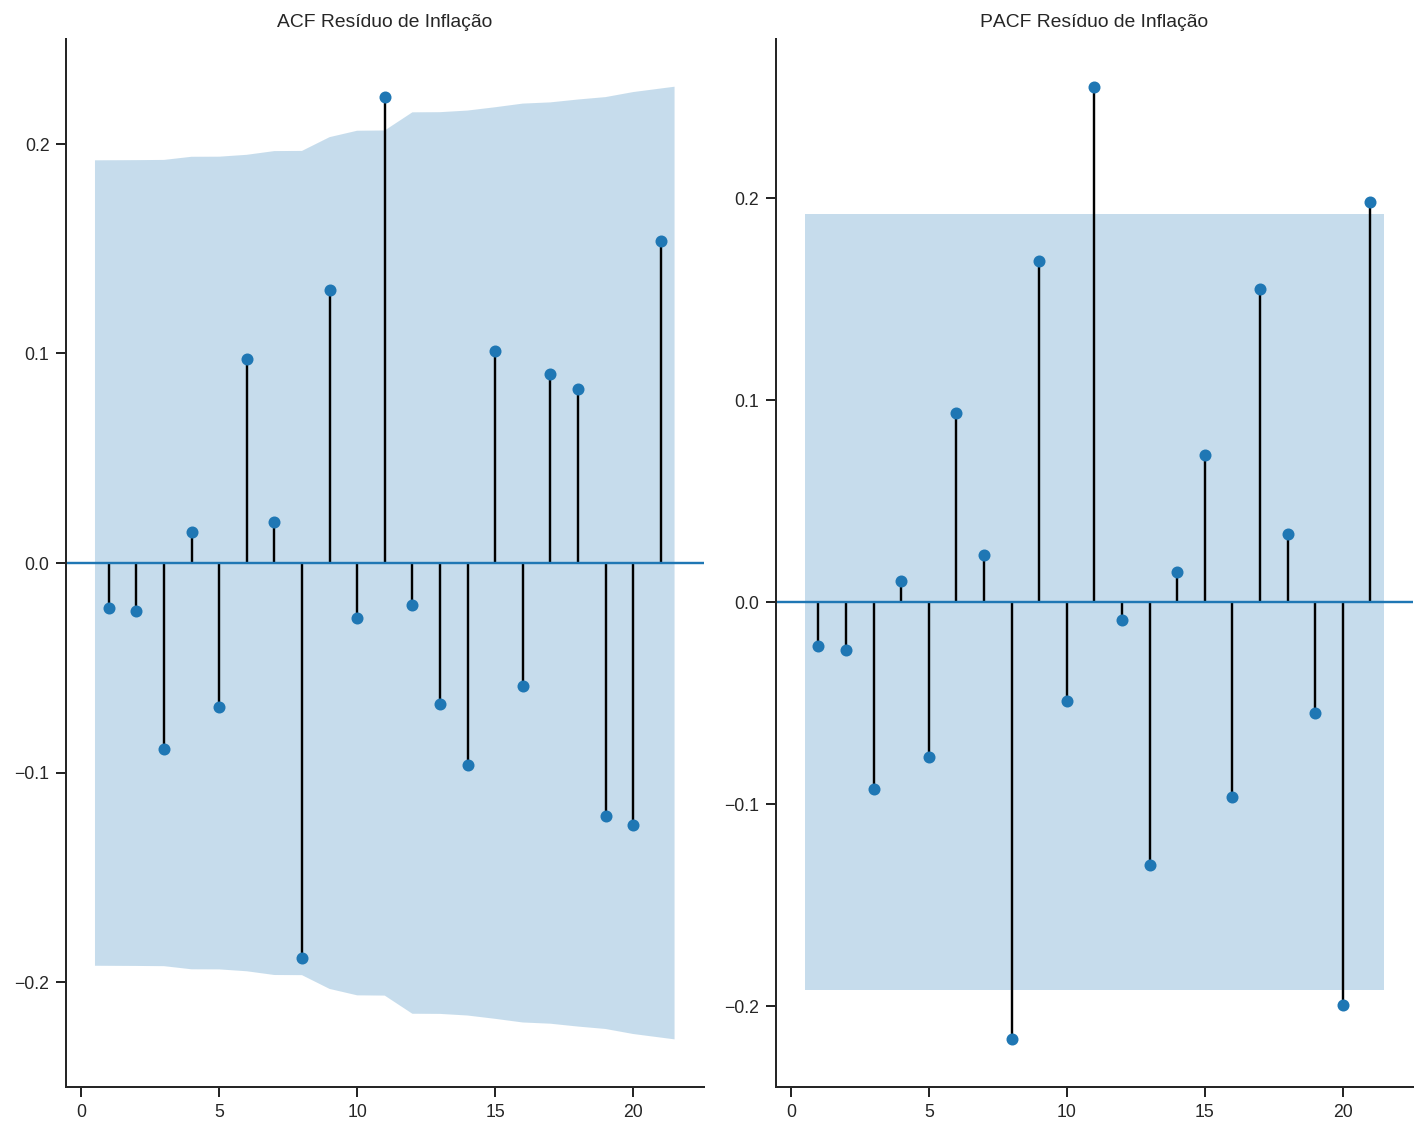

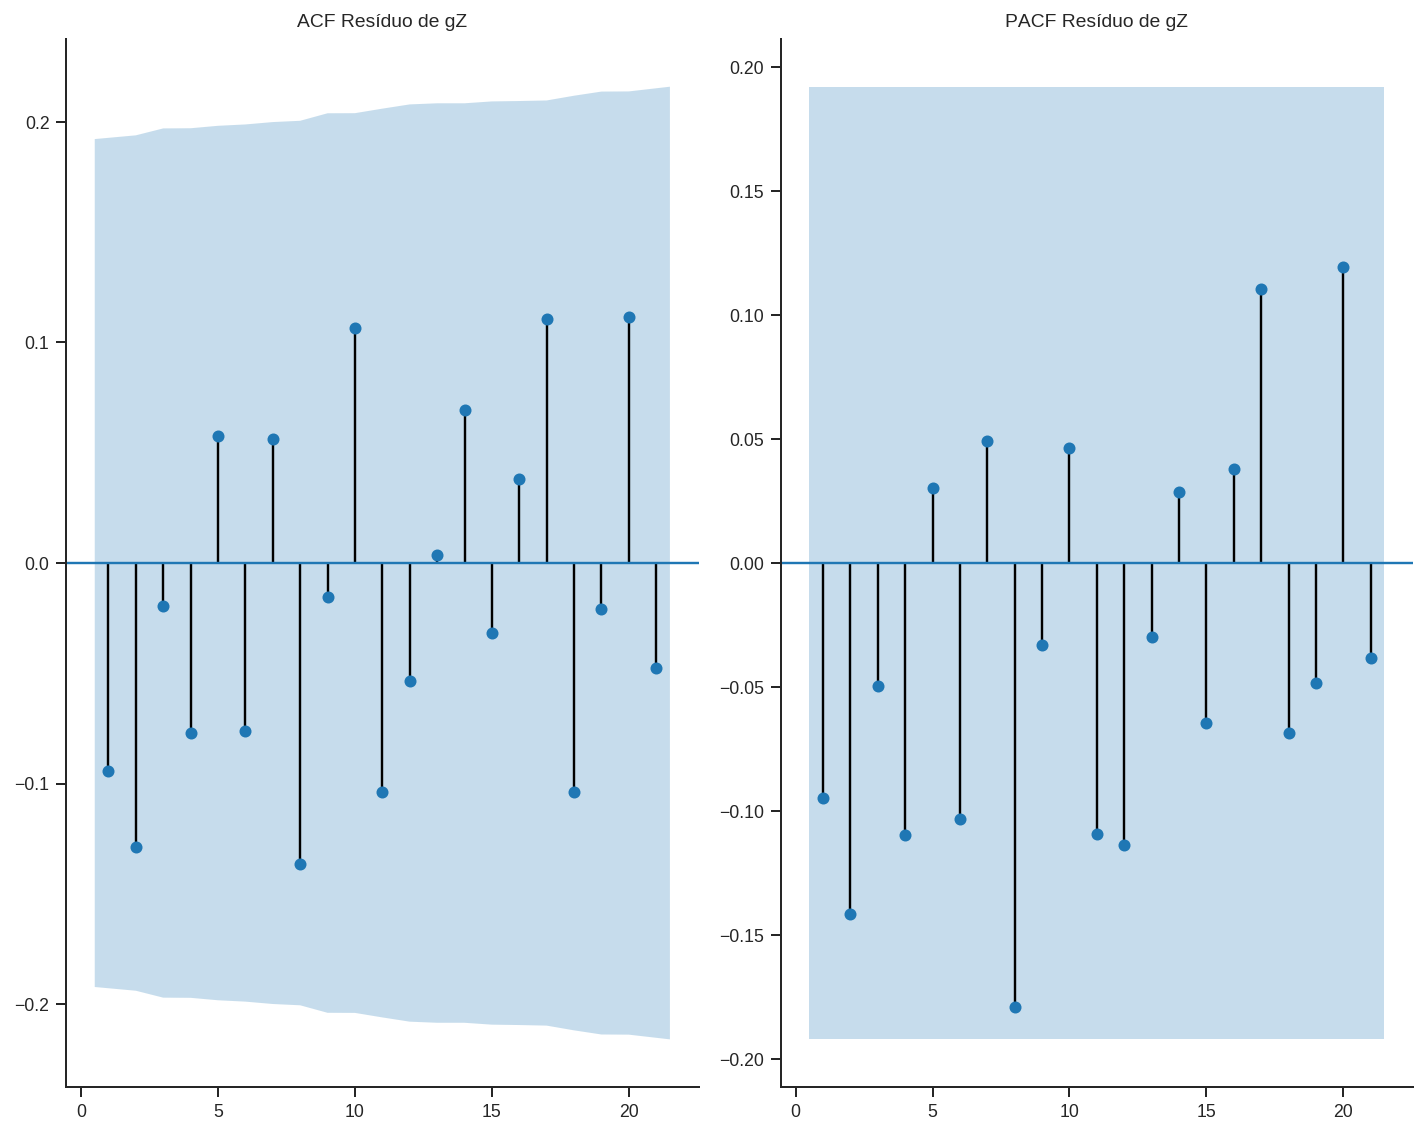

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         47.40          53.38   0.141 38
----------------------------------------

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         52.35          53.38   0.061 38
----------------------------------------

LJUNGBOX

H0: autocorrelations up to lag k equal zero
H1: autocorrelations up to lag k not zero
Box-Pierce:  False
Testing for  INFLAÇÃO . Considering a significance level of 5.0 %
Reject H0 on lag  1 ?  False
Reject H0 on lag  2 ?  False
Reject H0 on lag  3 ?  Fa

In [22]:
print(results.summary())
print(60*"=")
print("\nPÓS ESTIMAÇÂO\n")
residuals = analise_residuos(results=results)
print(60*"=")

## Função impulso resposta ortogonalizada

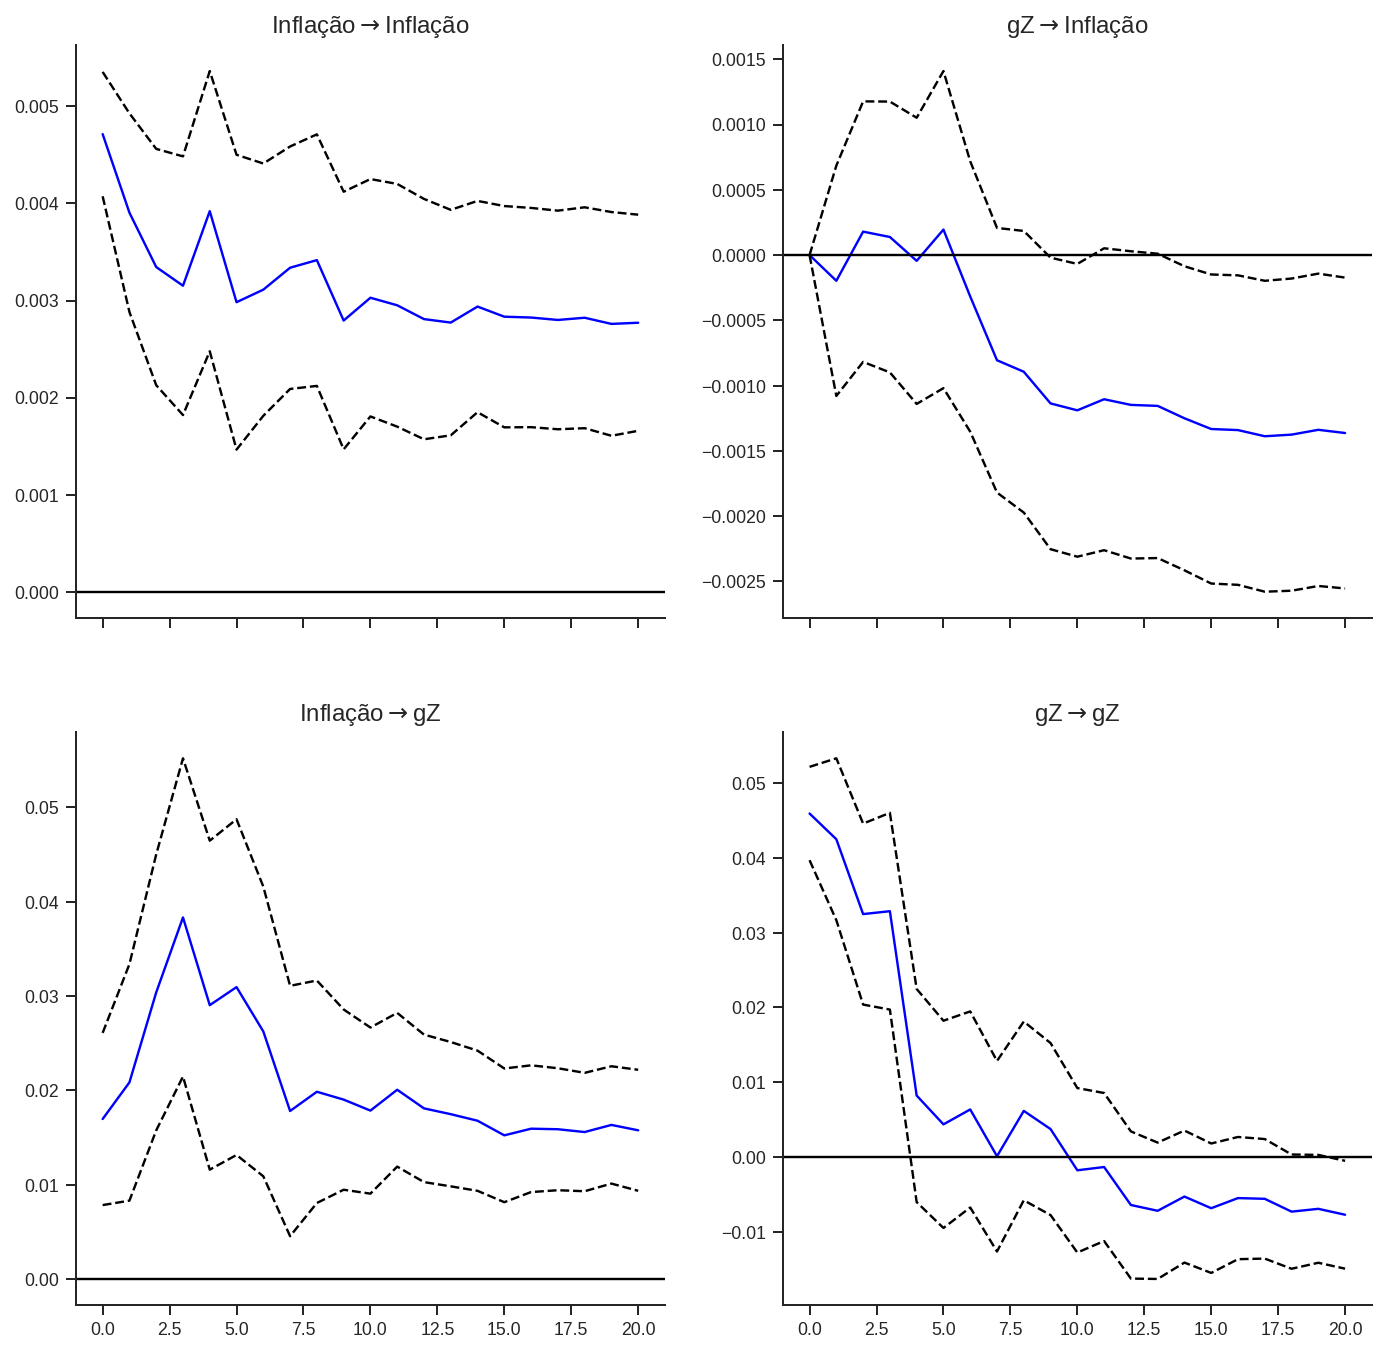

In [23]:
p = results.irf(20).plot(orth=True)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_VECMOrth.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

## Função impulso resposta não-ortogonalizada

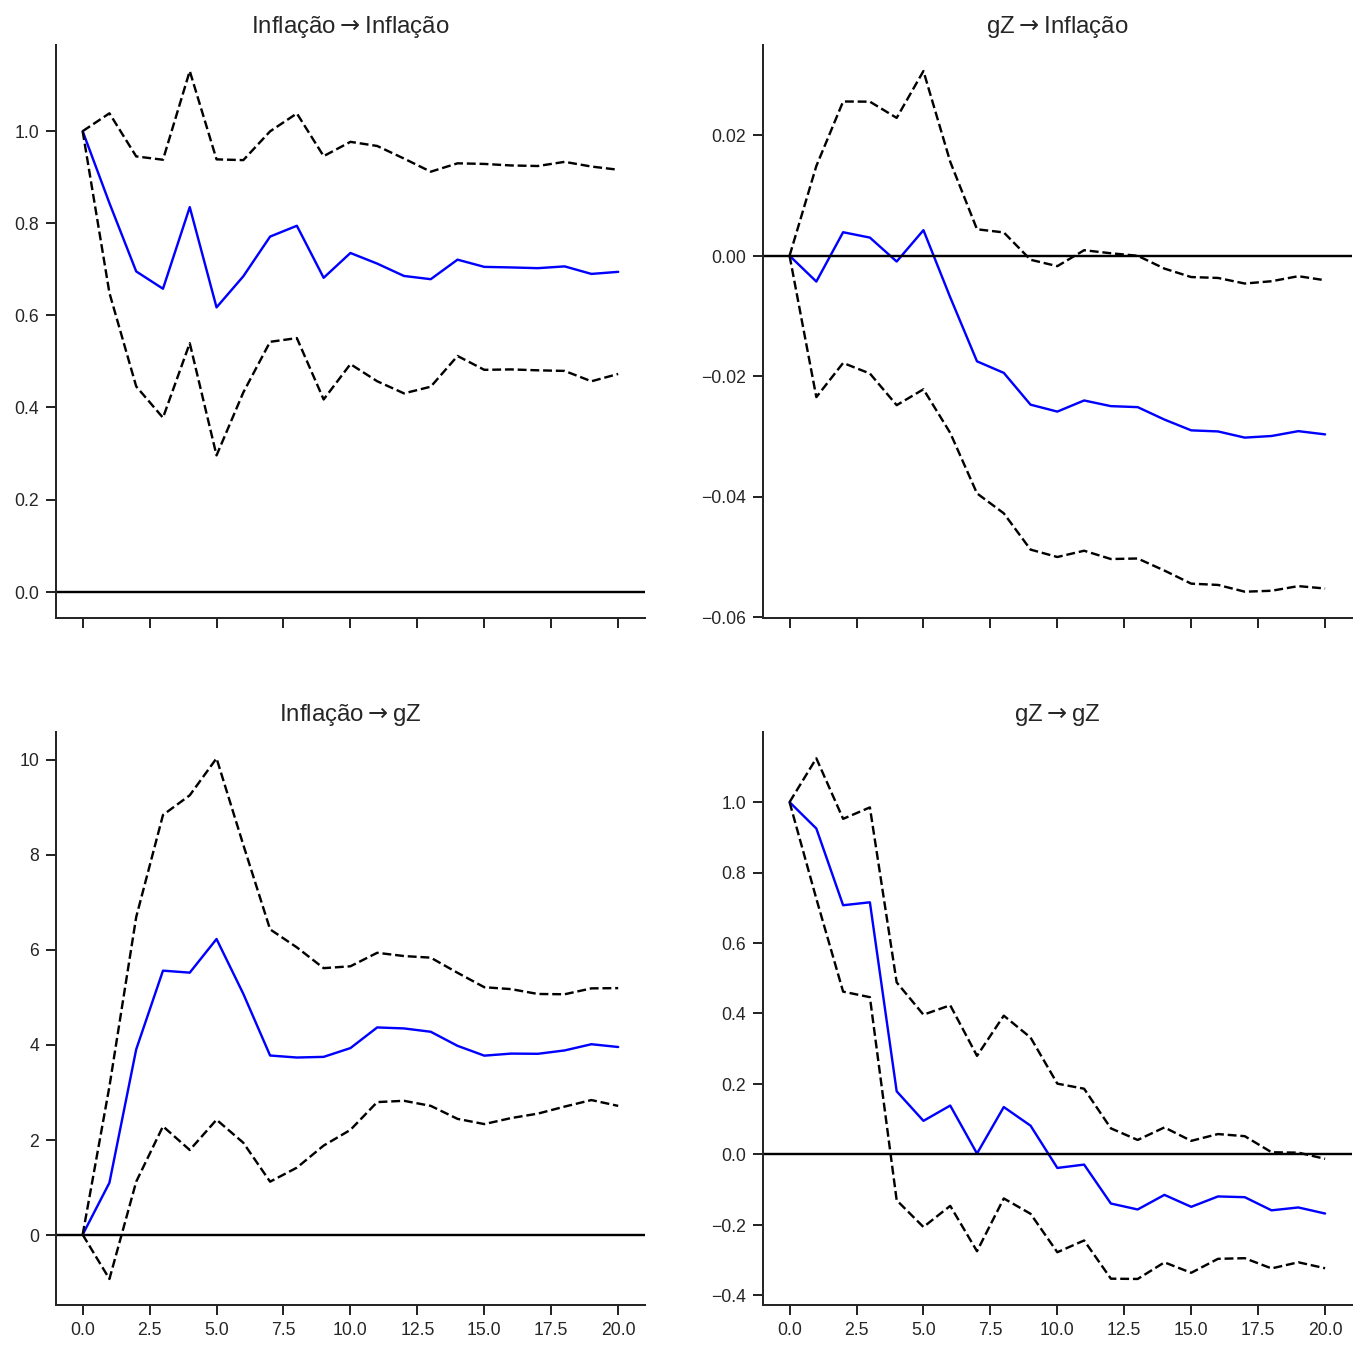

In [24]:
p = results.irf(20).plot(orth=False)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

# Teste de causalidade de granger

In [25]:
series = residuals.columns
print(results.test_granger_causality(causing=series[0], caused=series[1]).summary())
print(results.test_inst_causality(causing=series[0]).summary())

Granger causality F-test. H_0: Inflação does not Granger-cause gZ. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.983          2.152   0.071 (6, 172)
----------------------------------------------
Instantaneous causality Wald-test. H_0: Inflação does not instantaneously cause gZ. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         12.08          3.841   0.001  1
----------------------------------------


## Inspeção gráfica dos resíduos

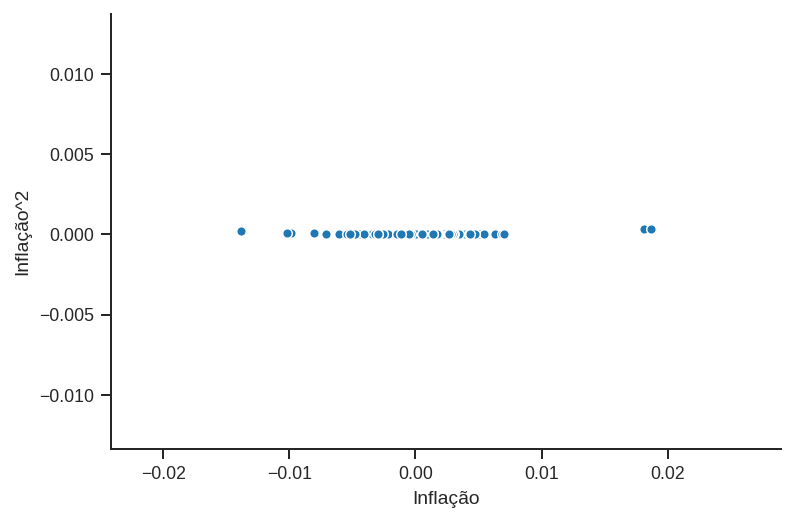

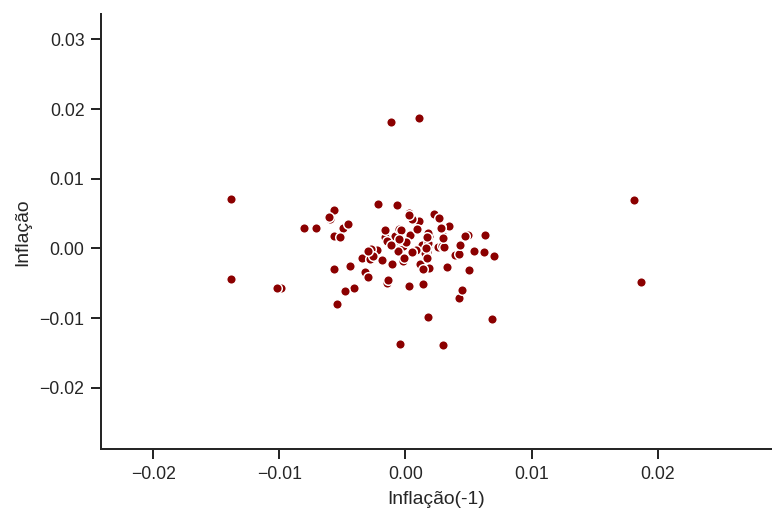

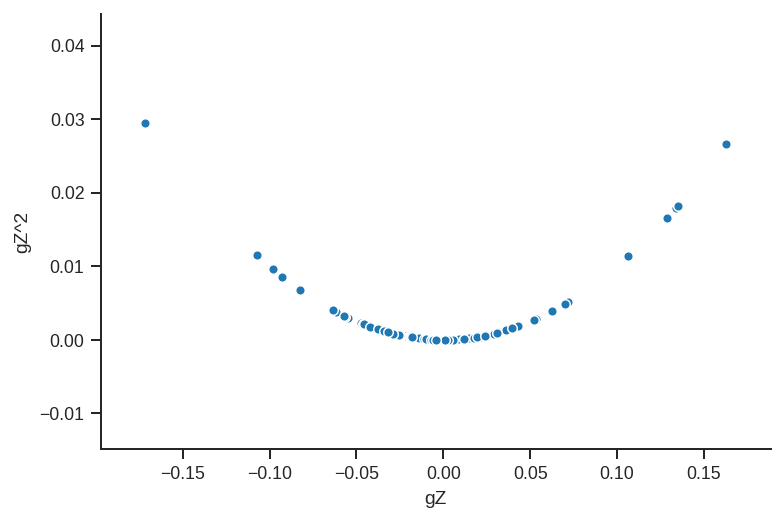

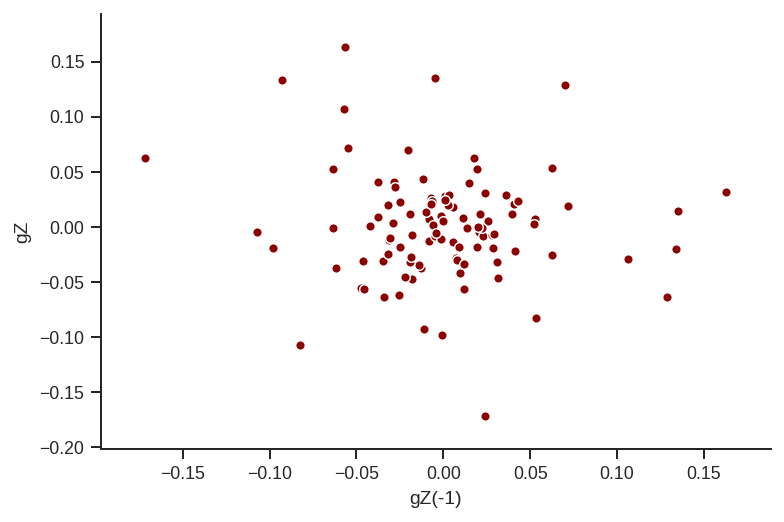

In [26]:
series = results.names
for serie in series:
    sns.scatterplot(x = residuals[serie], y = residuals[serie]**2)
    plt.ylabel(f"{serie}^2")
    sns.despine()
    plt.show()
    
    sns.scatterplot(
    y = residuals[serie], 
    x = residuals[serie].shift(-1), 
    color = 'darkred' 
    )
    sns.despine()
    plt.xlabel(f"{serie}(-1)")
    plt.show()

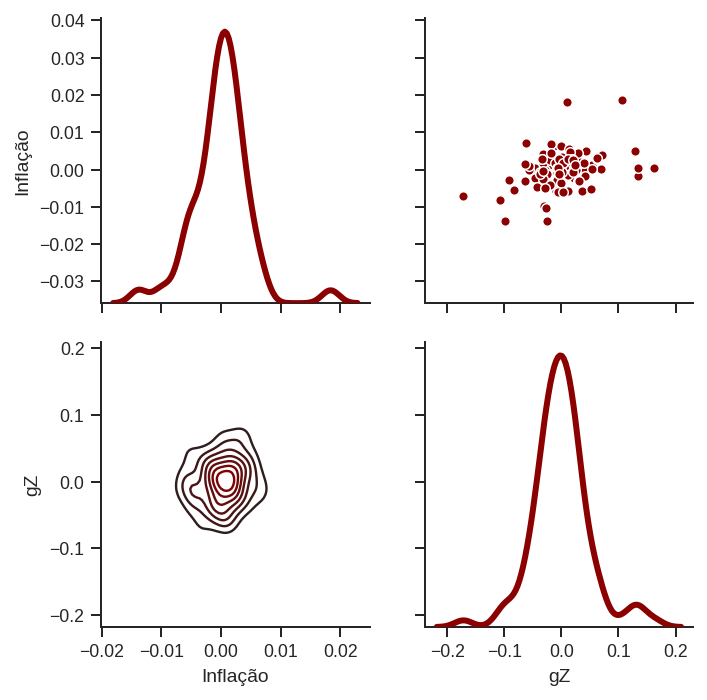

In [27]:
sns.set_context('paper')
g = sns.PairGrid(residuals, diag_sharey=False)
g.map_lower(sns.kdeplot, color = 'darkred')
g.map_upper(sns.scatterplot, color = 'darkred')
g.map_diag(sns.kdeplot, lw=3, color = 'darkred')
plt.show()
g.savefig("./figs/Residuos_4VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

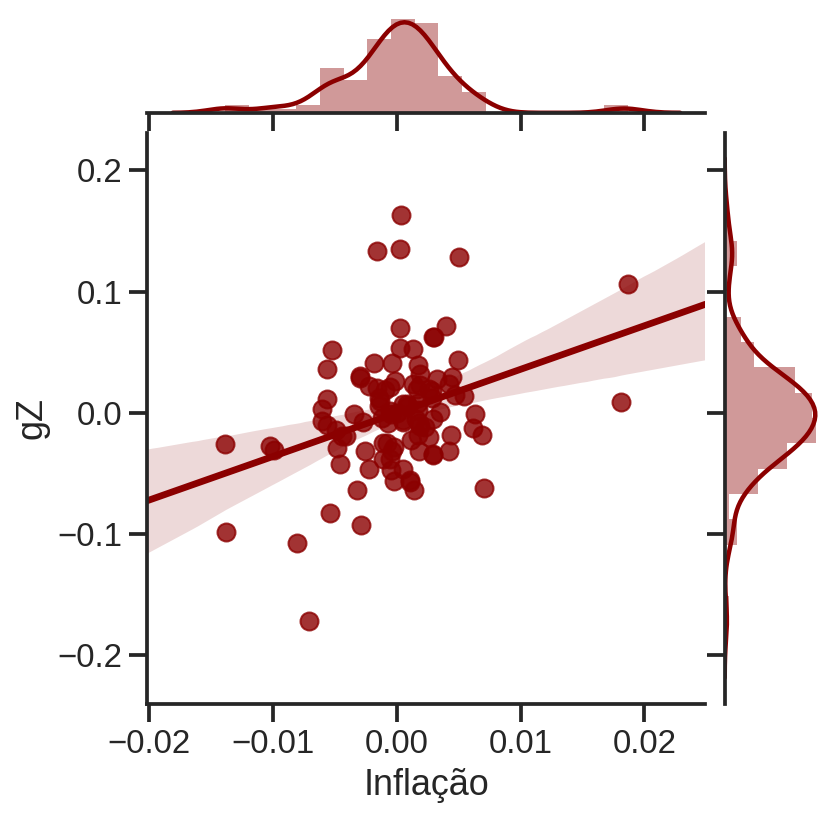

In [28]:
series = results.names
sns.set_context('talk')
ax = sns.jointplot(
    x = series[0], 
    y = series[1], 
    data = residuals, color = 'darkred', kind="reg", 
)
plt.show()

## FEVD

ATENÇÃO!!!!

In [29]:
%%R -o fevd_gz
library(tsDyn)
library(readr)
df <- read.csv("./Dados_yeojohnson.csv", encoding="UTF-8")
df <- df[,c(4:7)]
names(df) <- c("Juros", "Infla", "TaxaP", "gZ")
df <- na.omit(df[,c("Juros", "Infla","TaxaP", "gZ")])
df <- ts(data = df, start = c(1992,03), frequency = 4)
model <- tsDyn::VECM(data = df[,c("Infla","gZ")], lag = 4, r = 1, estim = "ML", LRinclude="both", include="trend", exogen = coredata(df[,"Juros"]))
fevd_gz = data.frame(tsDyn::fevd(model, 20)$gZ)

R[write to console]: Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff



In [30]:
%%R -o fevd_tx
fevd_tx = data.frame(tsDyn::fevd(model, 20)$Infla)

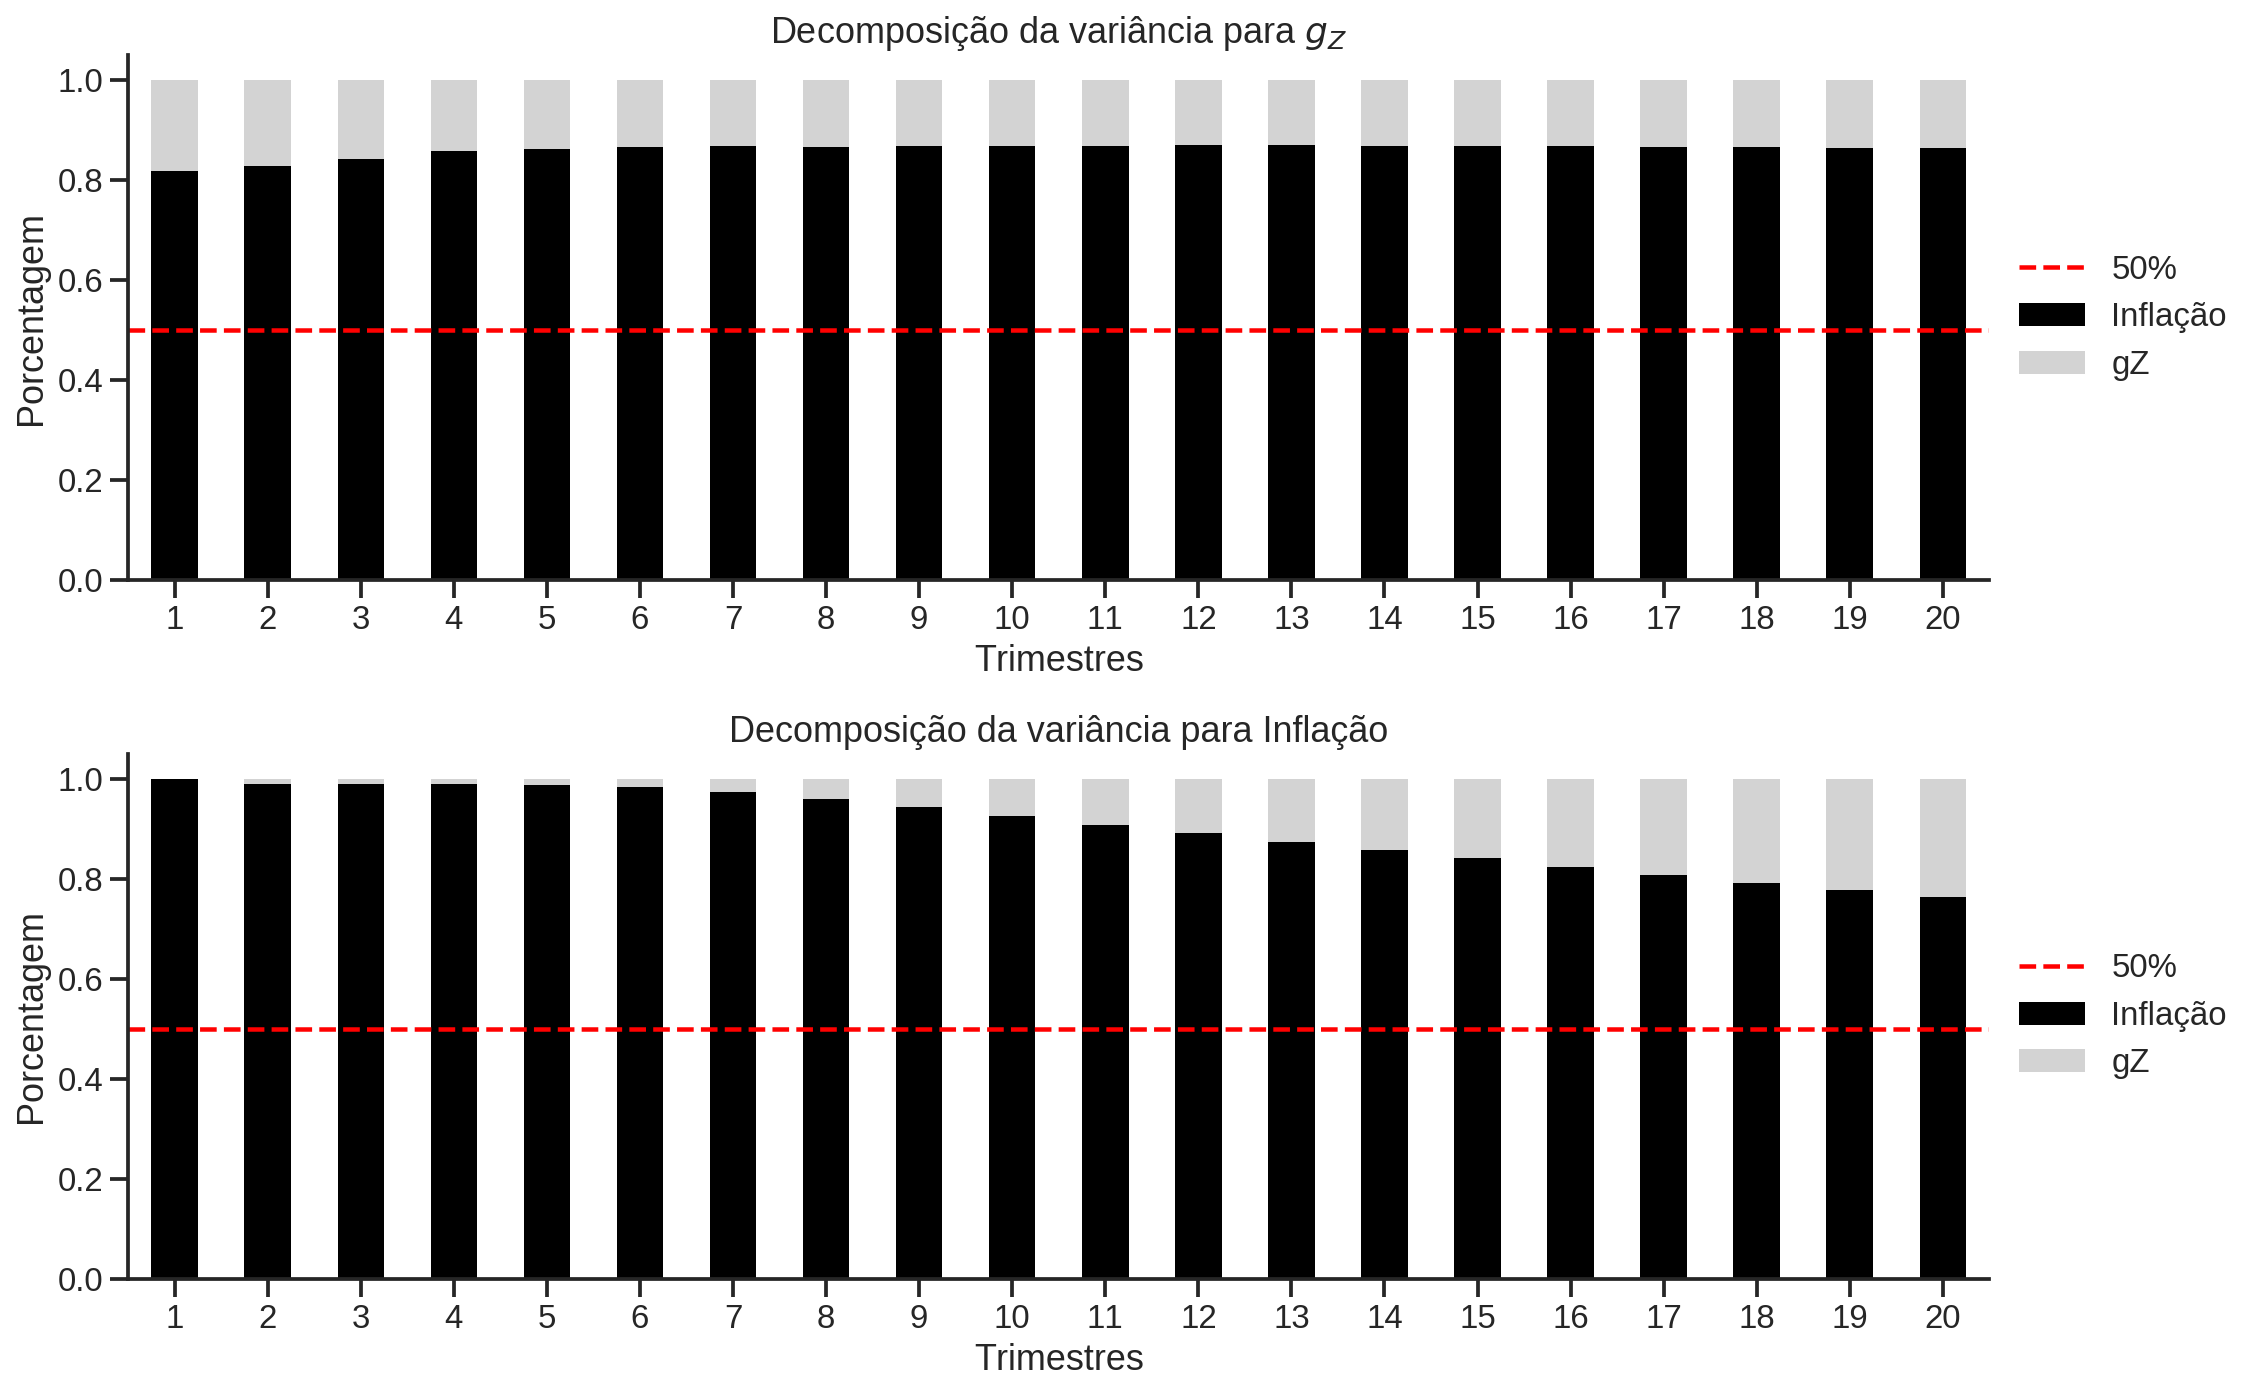

In [31]:
sns.set_context('talk')
fig, ax = plt.subplots(2,1, figsize = (16,10))

fevd_gz.plot(
    ax=ax[0], 
    title = "Decomposição da variância para $g_Z$", 
    color = ("black", "lightgray"), 
    kind = 'bar', stacked = True
)
ax[0].set_xlabel('Trimestres')
ax[0].set_ylabel('Porcentagem')
ax[0].axhline(y=0.5, color = 'red', ls = '--')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ("50%", "Inflação", "gZ"))
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)


fevd_tx.plot(
    ax=ax[1], 
    title = "Decomposição da variância para Inflação", 
    color = ("black", "lightgray"), 
    kind = 'bar', stacked = True,
)
ax[1].axhline(y=0.5, color = 'red', ls = '--')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ("50%", "Inflação", "gZ"))
ax[1].set_xlabel('Trimestres')
ax[1].set_ylabel('Porcentagem')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)

sns.despine()
plt.tight_layout()
plt.show()
fig.savefig("./figs/FEVD_VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

# VAR

**Dúvida:** Variável exógena do VAR deve ser estacionária também?

## Ordem do modelo

In [32]:
model = VAR(
    df[["d_Inflação", 'd_gZ']],
    exog=df['Taxa de juros']
)
print(model.select_order(maxlags=15, trend='ct').summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -15.97     -15.81*   1.163e-07     -15.90*
1       -15.93      -15.66   1.205e-07      -15.82
2       -15.91      -15.54   1.226e-07      -15.76
3       -15.89      -15.40   1.261e-07      -15.69
4       -16.11      -15.52   1.006e-07      -15.88
5      -16.15*      -15.45  9.714e-08*      -15.87
6       -16.12      -15.31   1.007e-07      -15.79
7       -16.05      -15.14   1.079e-07      -15.68
8       -16.09      -15.07   1.041e-07      -15.68
9       -16.01      -14.88   1.132e-07      -15.55
10      -15.99      -14.75   1.163e-07      -15.49
11      -16.02      -14.68   1.130e-07      -15.48
12      -15.98      -14.53   1.186e-07      -15.39
13      -15.94      -14.38   1.247e-07      -15.31
14      -15.91      -14.24   1.297e-07      -15.23
15      -15.85      -14.08   1.388e-07      -15.13
-------------------------------

Adotando o BIC como critério de seleção dada a parciomônia, estima-se uma VAR de ordem 5.

## Estimação

In [33]:
results = model.fit(maxlags=8)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           ter, 10, dez, 2019
Time:                     17:59:33
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -15.1753
Nobs:                     102.000    HQIC:                  -15.7266
Log likelihood:           567.727    FPE:                1.02407e-07
AIC:                     -16.1018    Det(Omega_mle):     7.39887e-08
--------------------------------------------------------------------
Results for equation d_Inflação
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.000822         0.002011            0.409           0.683
exog0                -0.011209         0.033814           -0.331           0.740
L1.d_Inflação        -0.161935         0.115191        

## Pós-estimação

### Autocorrelação dos resíduos 

**OBS:** série consigo mesma na diagonal principal.

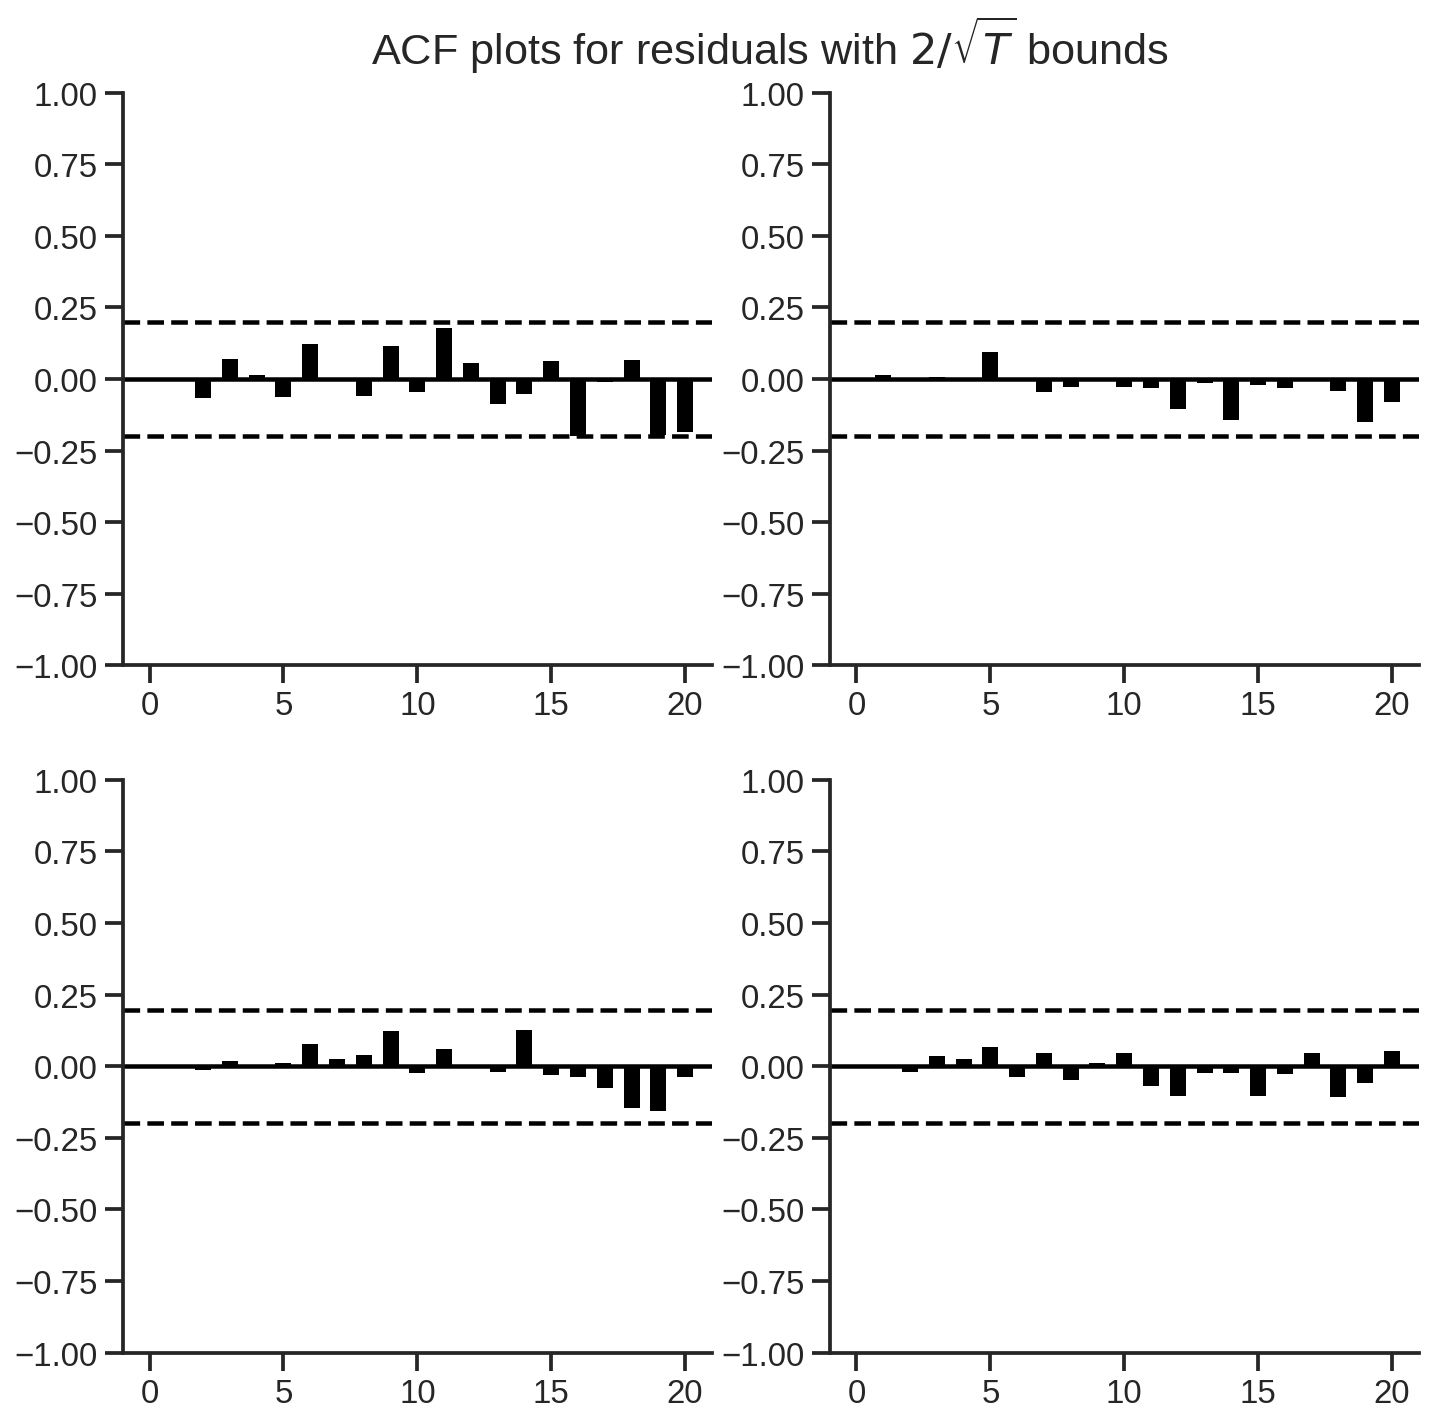

In [34]:
results.plot_acorr(nlags = 20)
sns.despine()
plt.show()

**Conclusão:** Pela inspeção gráfica, o modelo não apresenta autocorrelação serial dos resíduos.

### Estabilidade

In [35]:
print("Estável:", results.is_stable(verbose=True))

Eigenvalues of VAR(1) rep
0.8295422799852575
0.8295422799852575
0.8648306583386408
0.8648306583386408
0.8337767702442895
0.8337767702442895
0.6987740987631741
0.6987740987631741
0.9088828620685458
0.9088828620685458
0.8413931582509593
0.8413931582509593
0.7629377039768521
0.7629377039768521
0.7307692888293126
0.7307692888293126
Estável: True


**OBS:** Apesar de estar escrito VAR(1), os resultados acima correspondem ao VAR(p)

## Inspeção dos resíduos

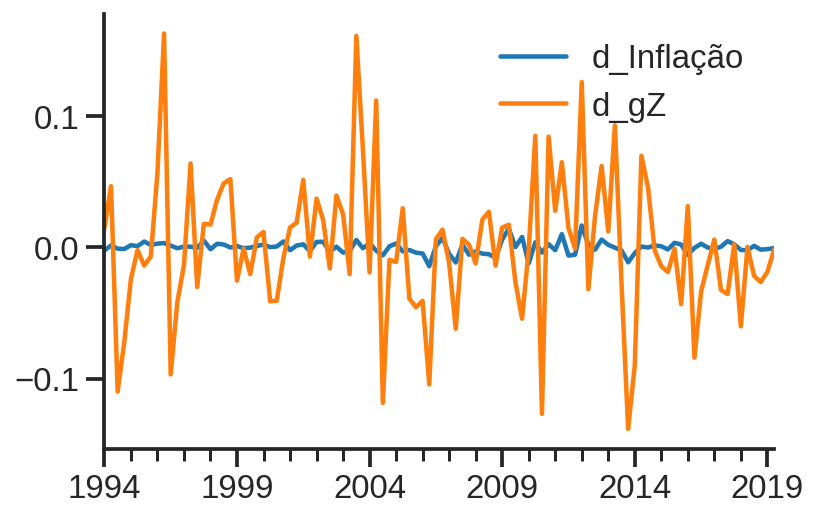

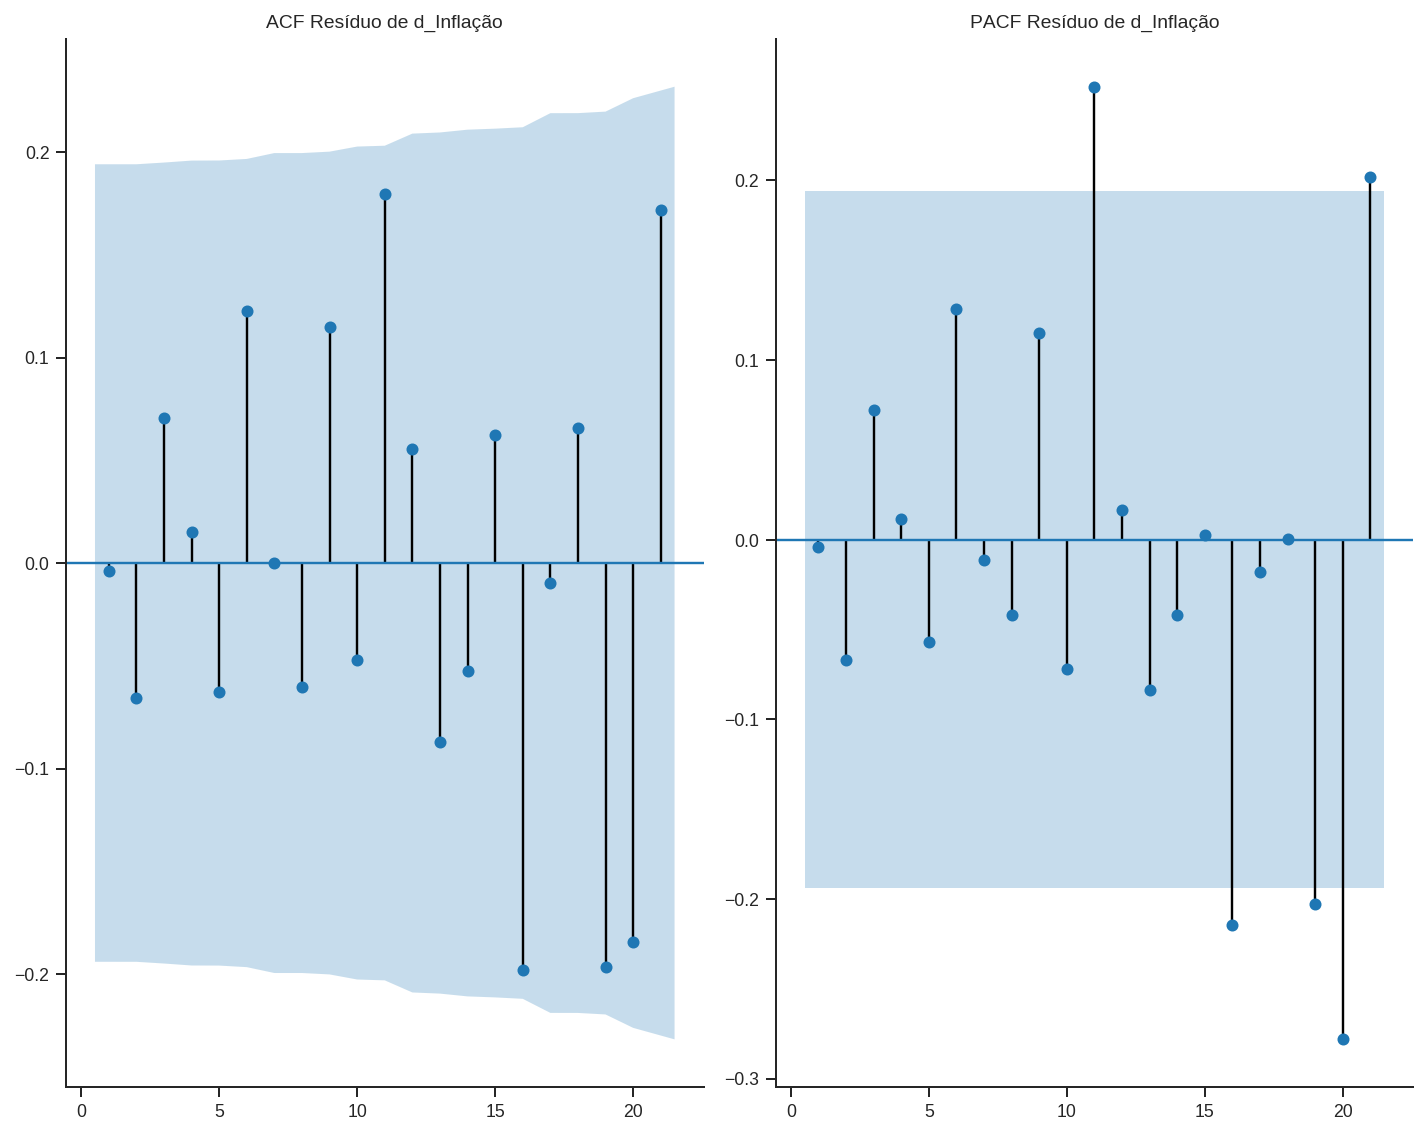

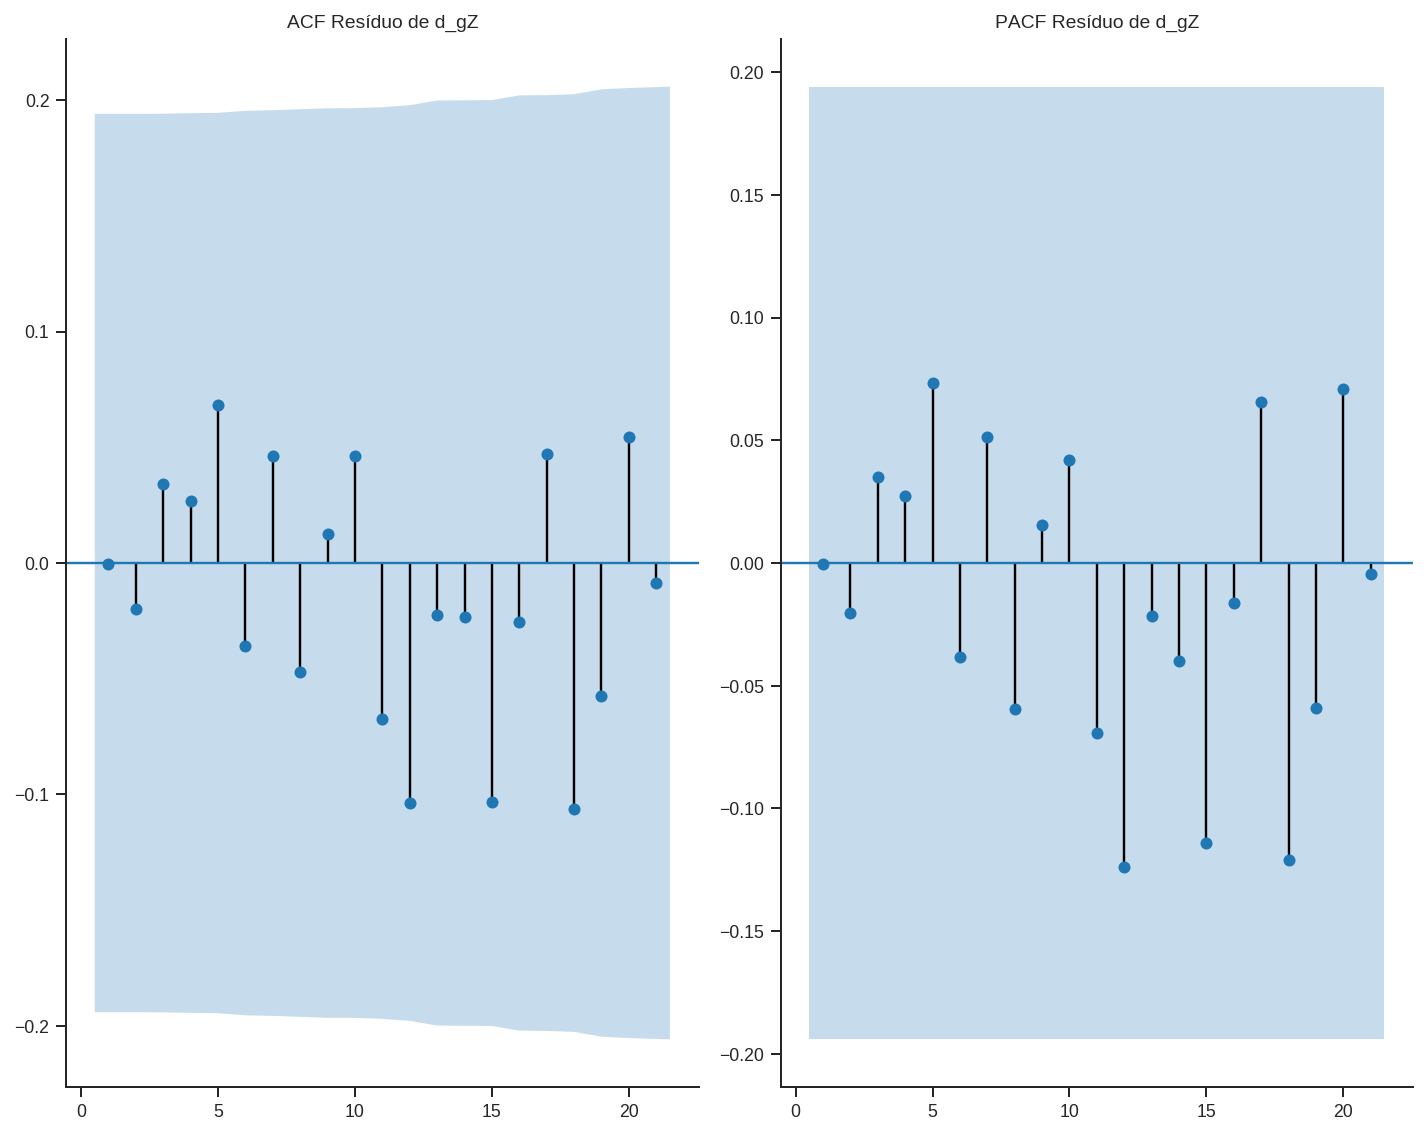

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         27.59          41.34   0.486 28
----------------------------------------

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         30.64          41.34   0.333 28
----------------------------------------

LJUNGBOX

H0: autocorrelations up to lag k equal zero
H1: autocorrelations up to lag k not zero
Box-Pierce:  False
Testing for  D_INFLAÇÃO . Considering a significance level of 5.0 %
Reject H0 on lag  1 ?  False
Reject H0 on lag  2 ?  False
Reject H0 on lag  3 ?  

In [36]:
residuals = analise_residuos(results=results)

## Inspeção gráfica dos resíduos

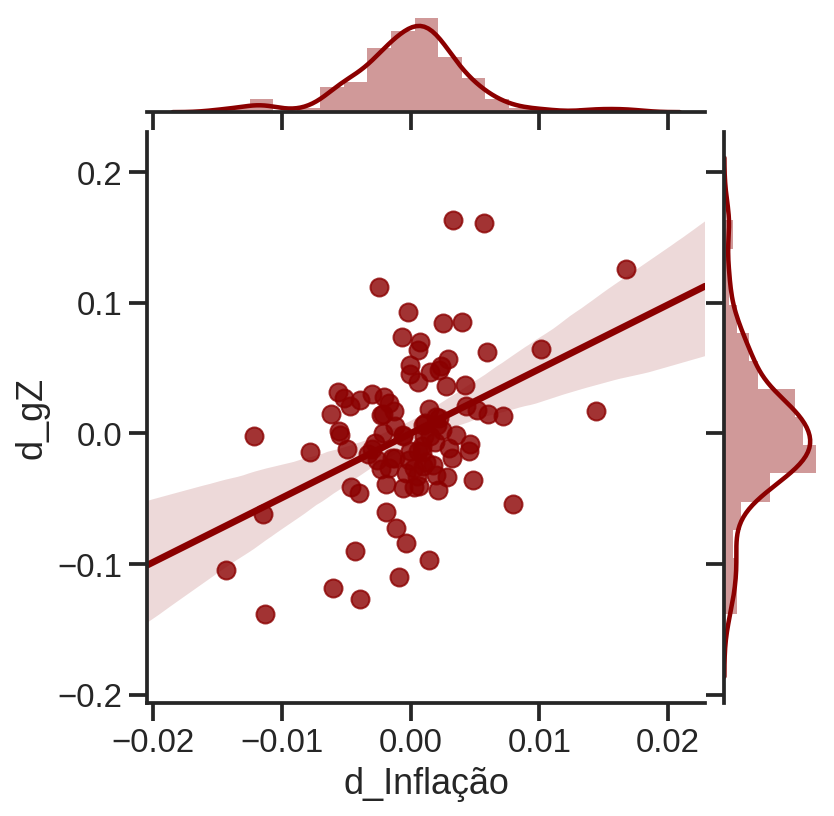

In [37]:
series = results.names
sns.set_context('talk')
ax = sns.jointplot(
    x = series[0], 
    y = series[1], 
    data = residuals, color = 'darkred', kind="reg", 
)
plt.show()

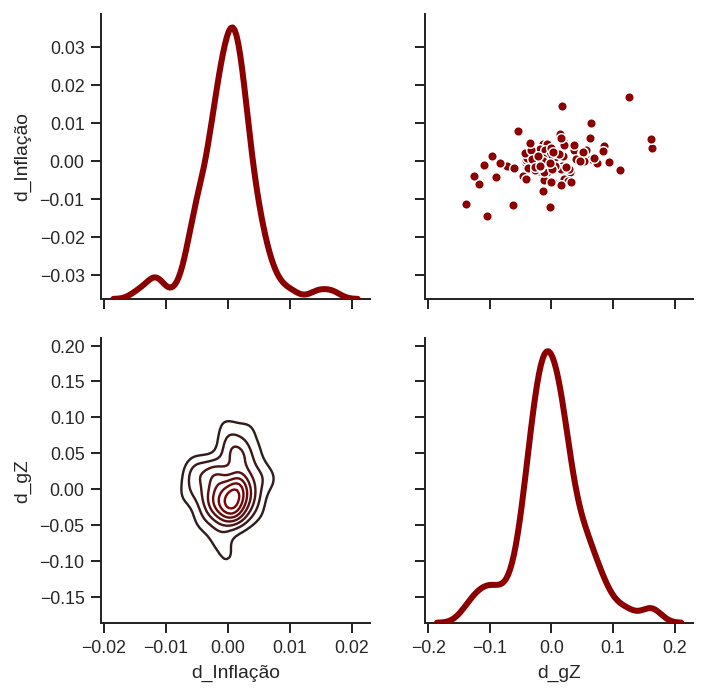

In [38]:
sns.set_context('paper')
g = sns.PairGrid(residuals, diag_sharey=False)
g.map_lower(sns.kdeplot, color = 'darkred')
g.map_upper(sns.scatterplot, color = 'darkred')
g.map_diag(sns.kdeplot, lw=3, color = 'darkred')
plt.show()
g.savefig("./figs/Residuos_4.png", dpi=300)

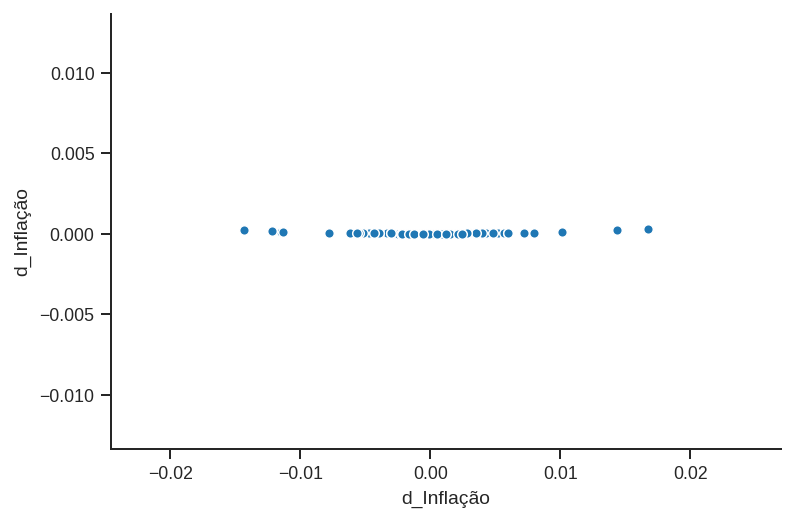

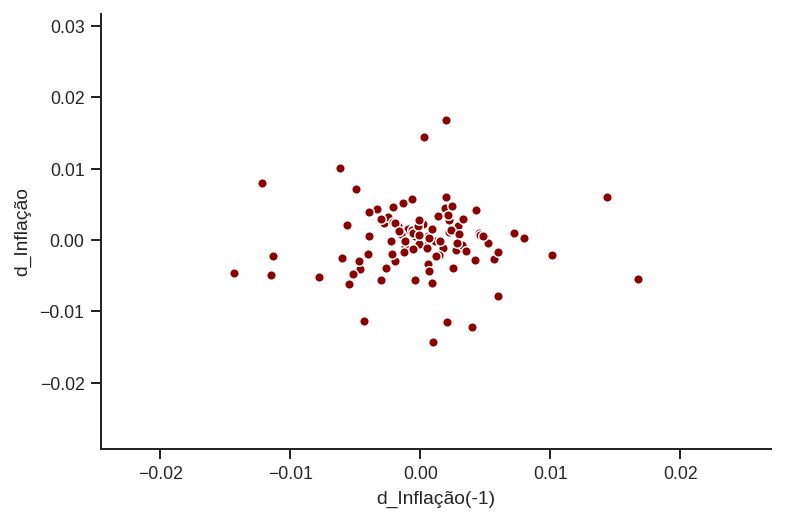

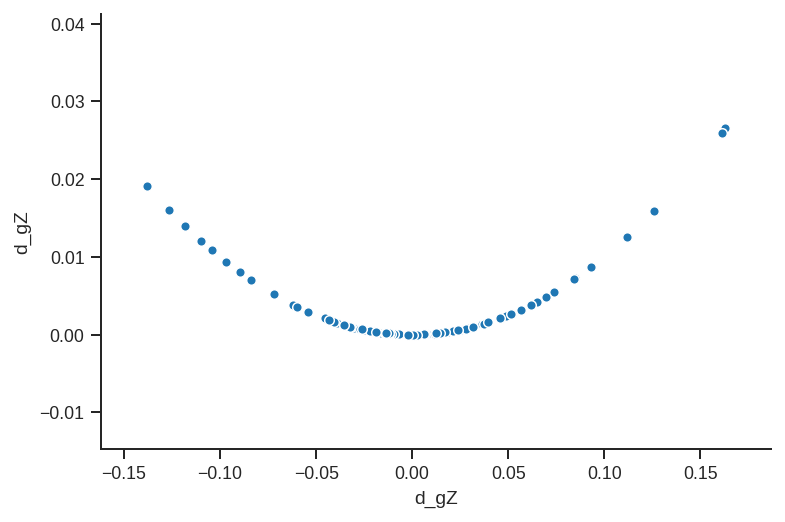

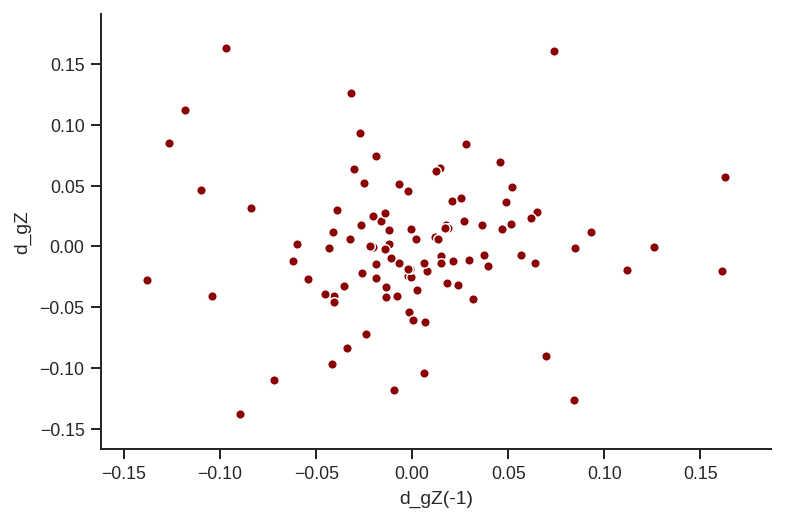

In [39]:
series = results.names
for serie in series:
    sns.scatterplot(x = residuals[serie], y = residuals[serie]**2)
    sns.despine()
    plt.show()
    
    sns.scatterplot(
    y = residuals[serie], 
    x = residuals[serie].shift(-1), 
    color = 'darkred' 
    )
    sns.despine()
    plt.xlabel(f"{serie}(-1)")
    plt.show()

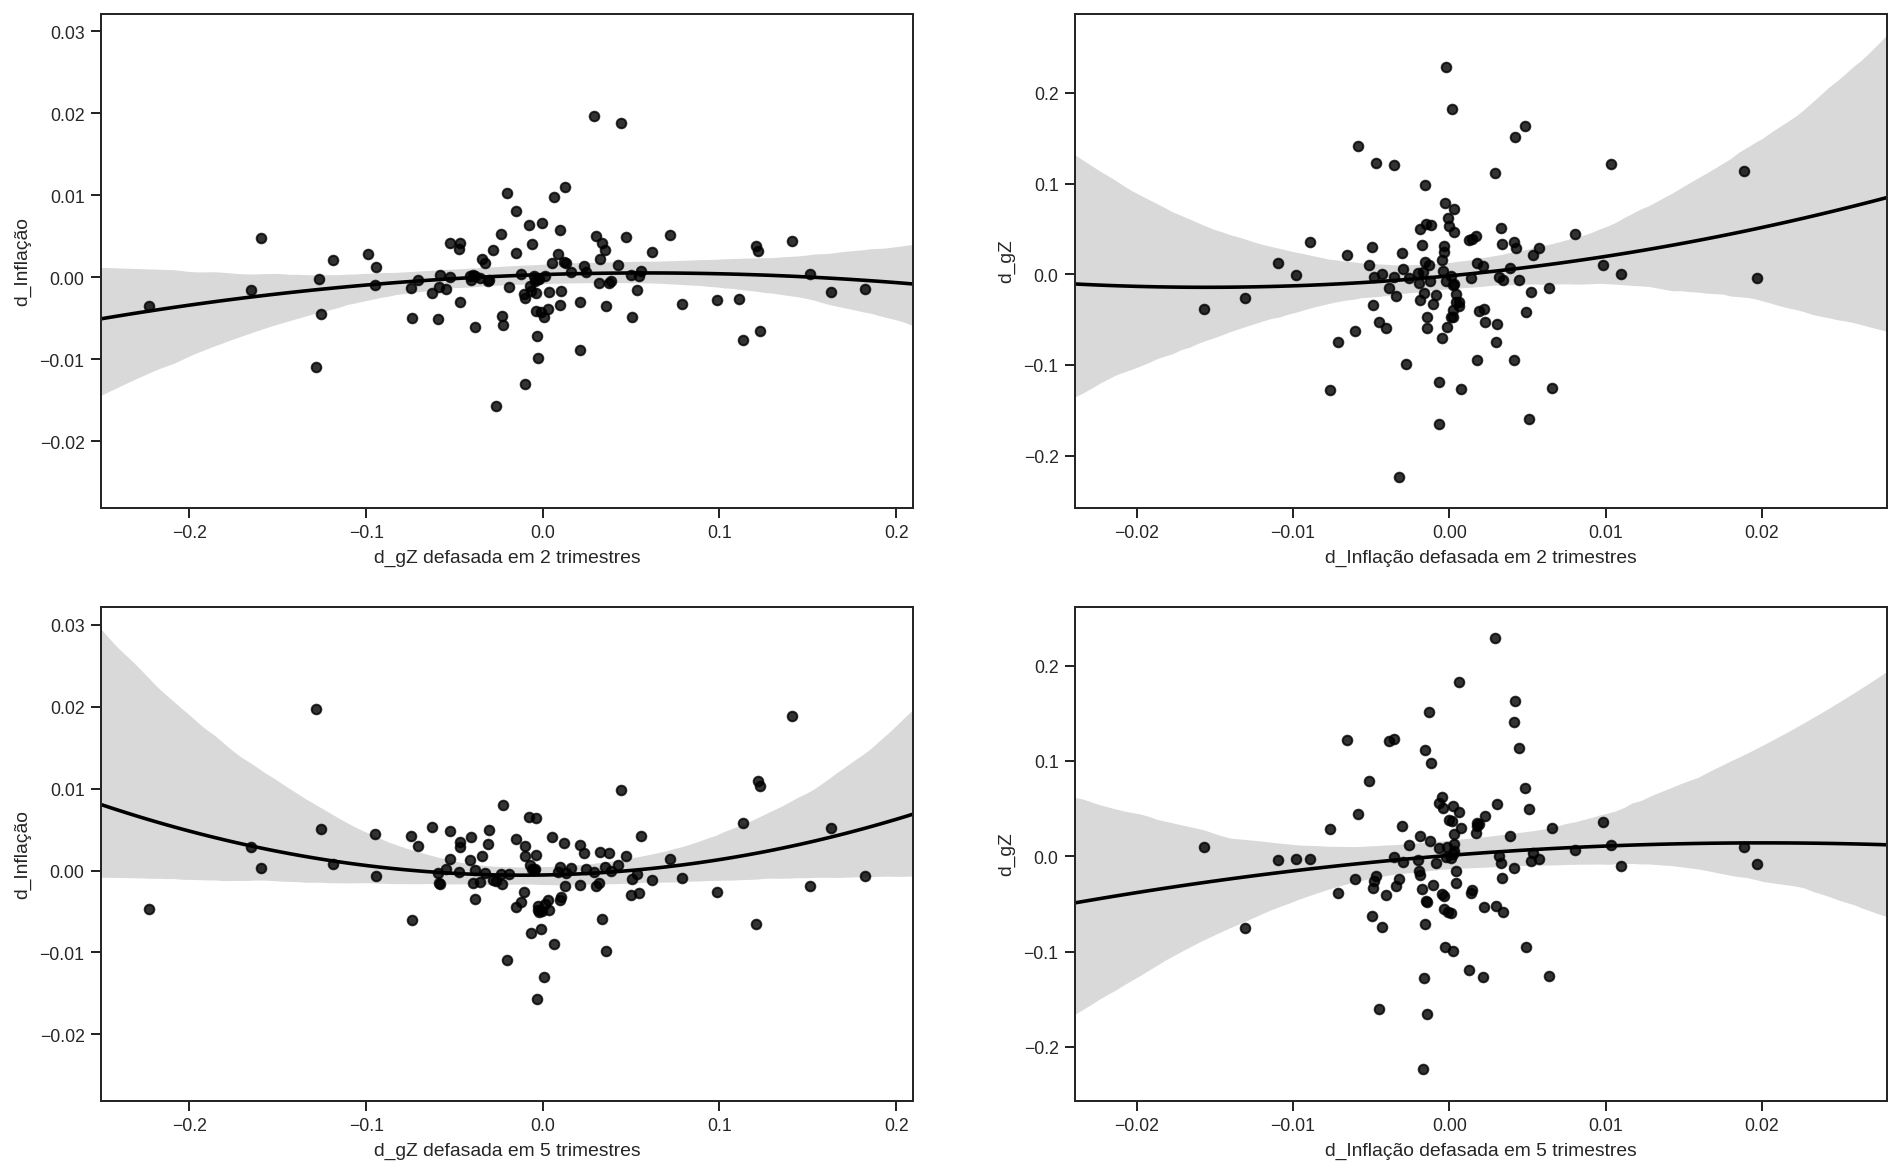

In [40]:
plot_lags(results=results)

## Função resposta ao impulso ortogonalizada

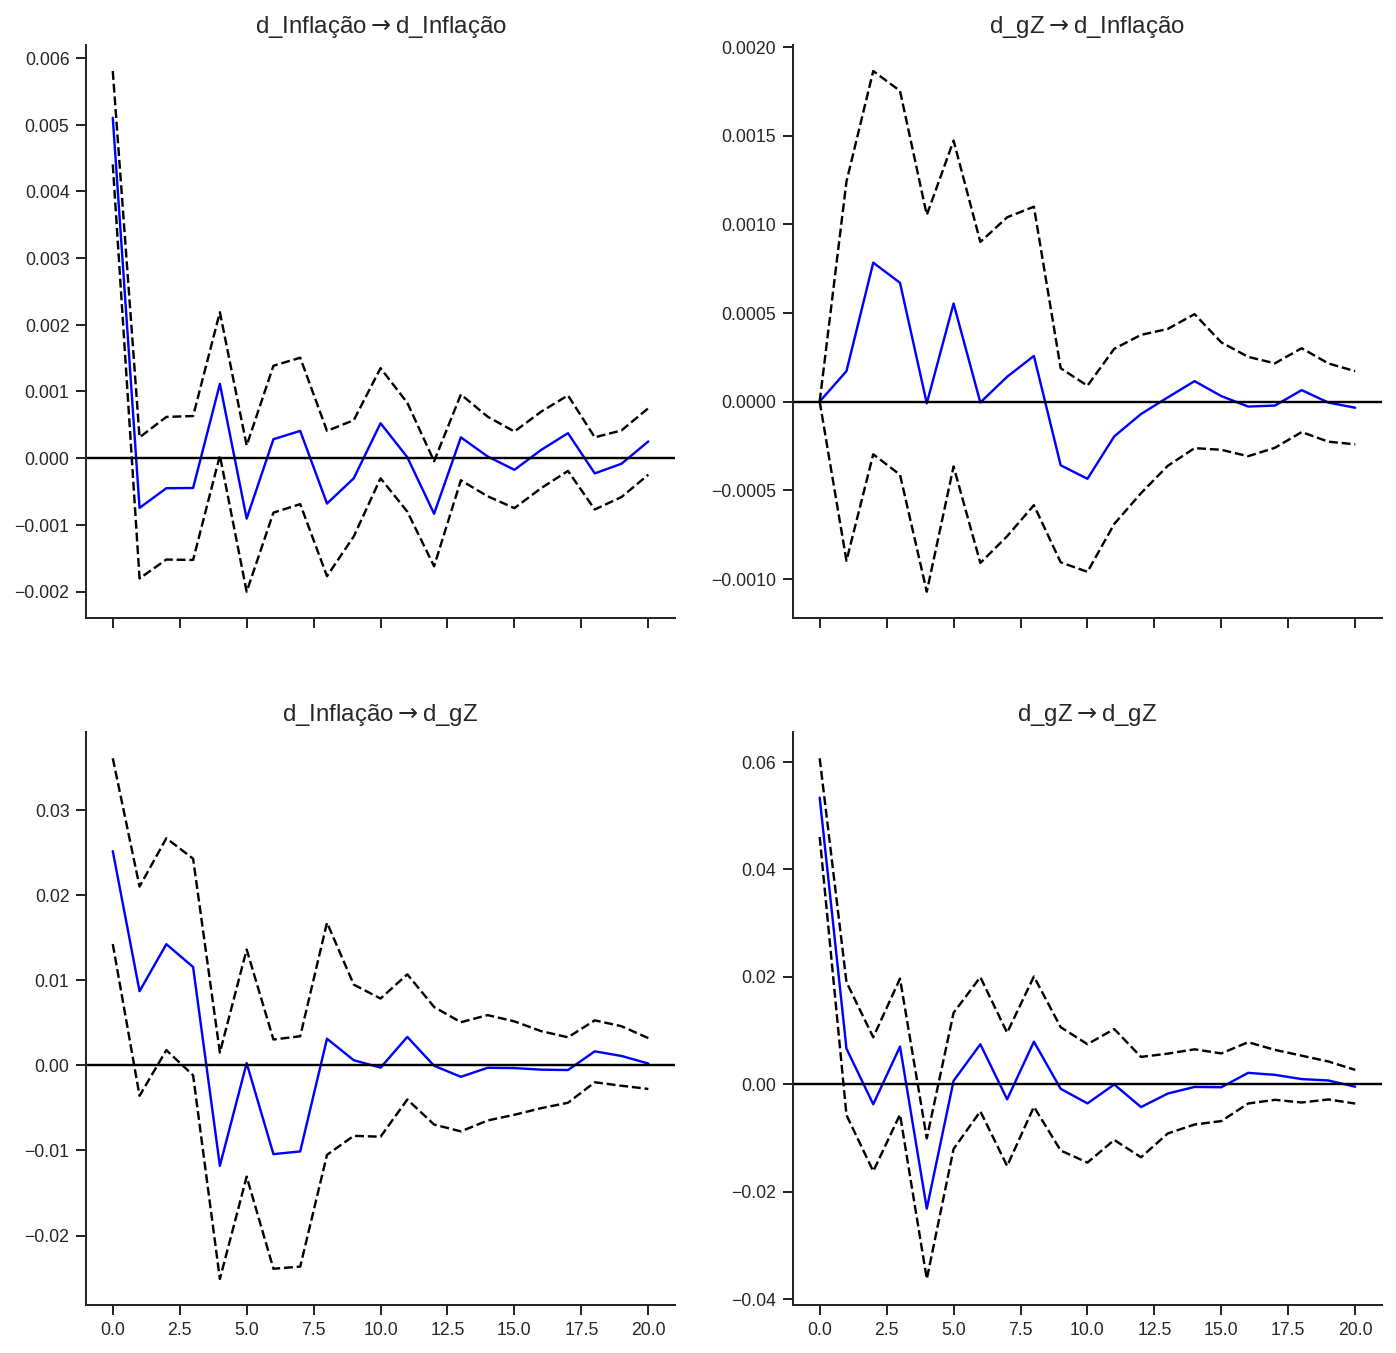

In [41]:
p = results.irf(20).plot(orth=True)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_Orth.png", dpi = 300)

## Função resposta ao impulso não-ortogonalizada

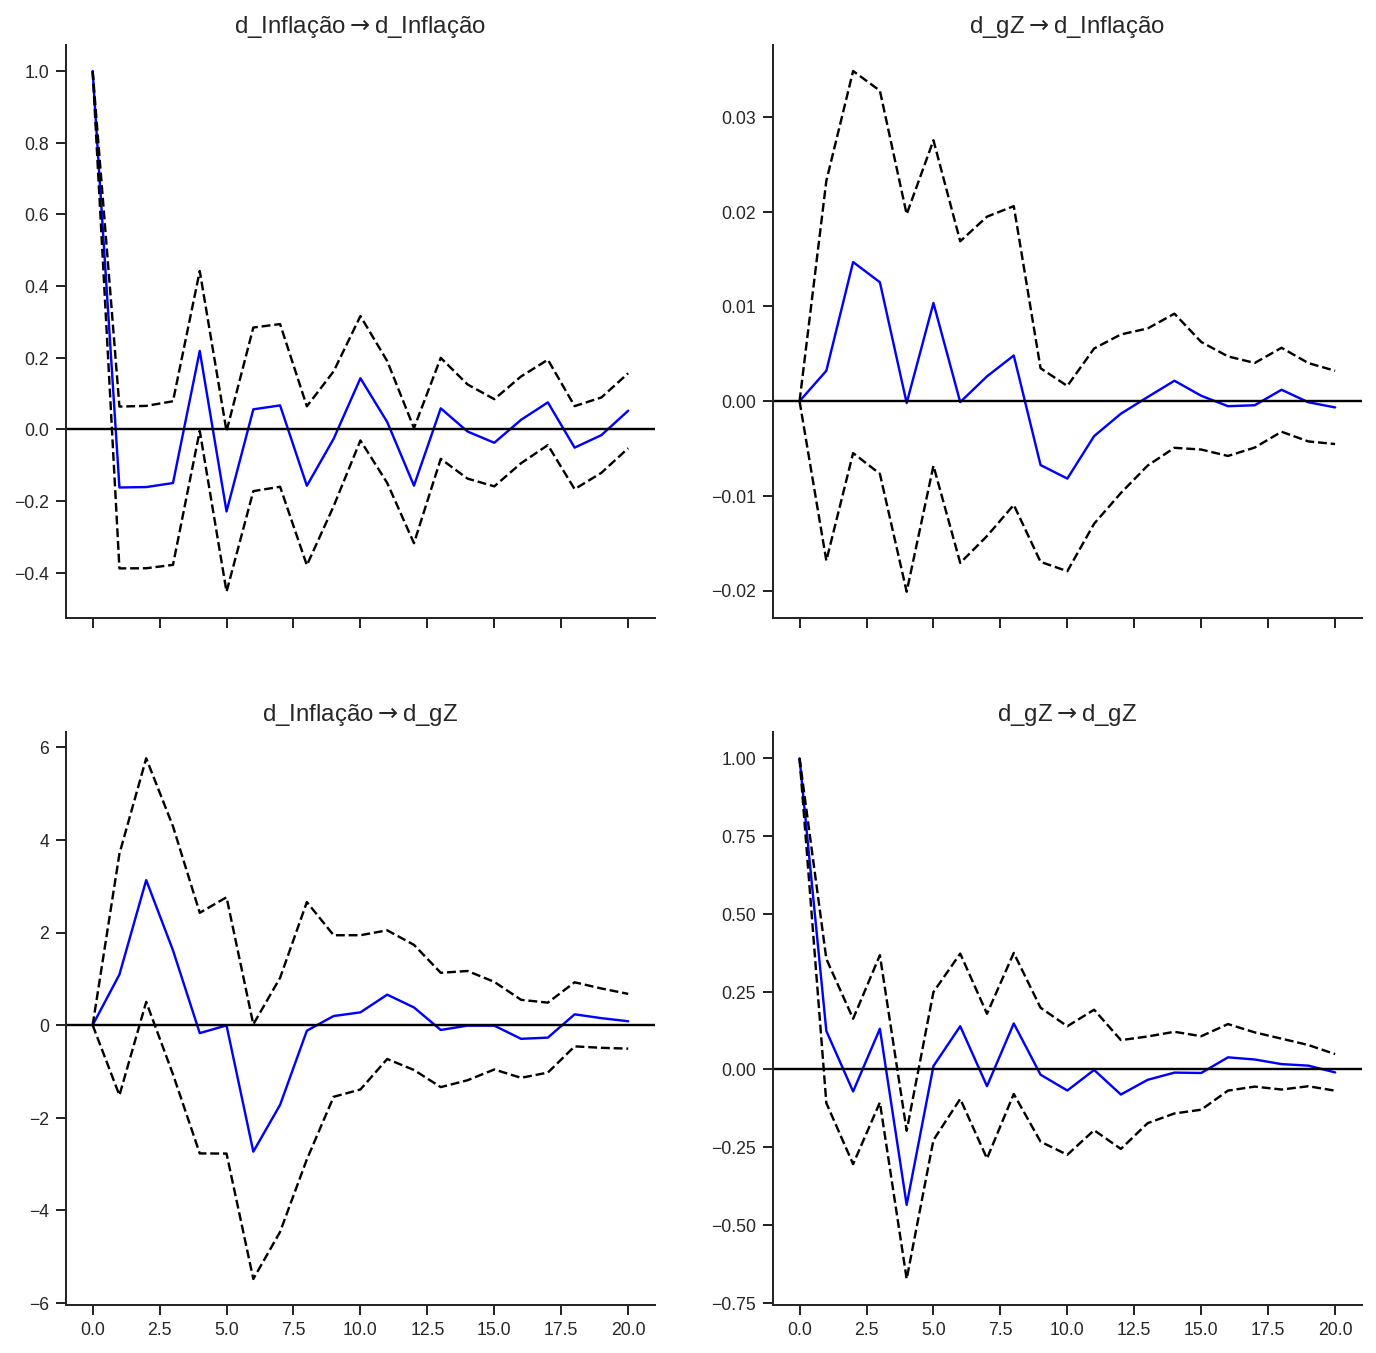

In [42]:
p = results.irf(20).plot(orth=False)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso.png", dpi = 300)

## Efeito cumulativo

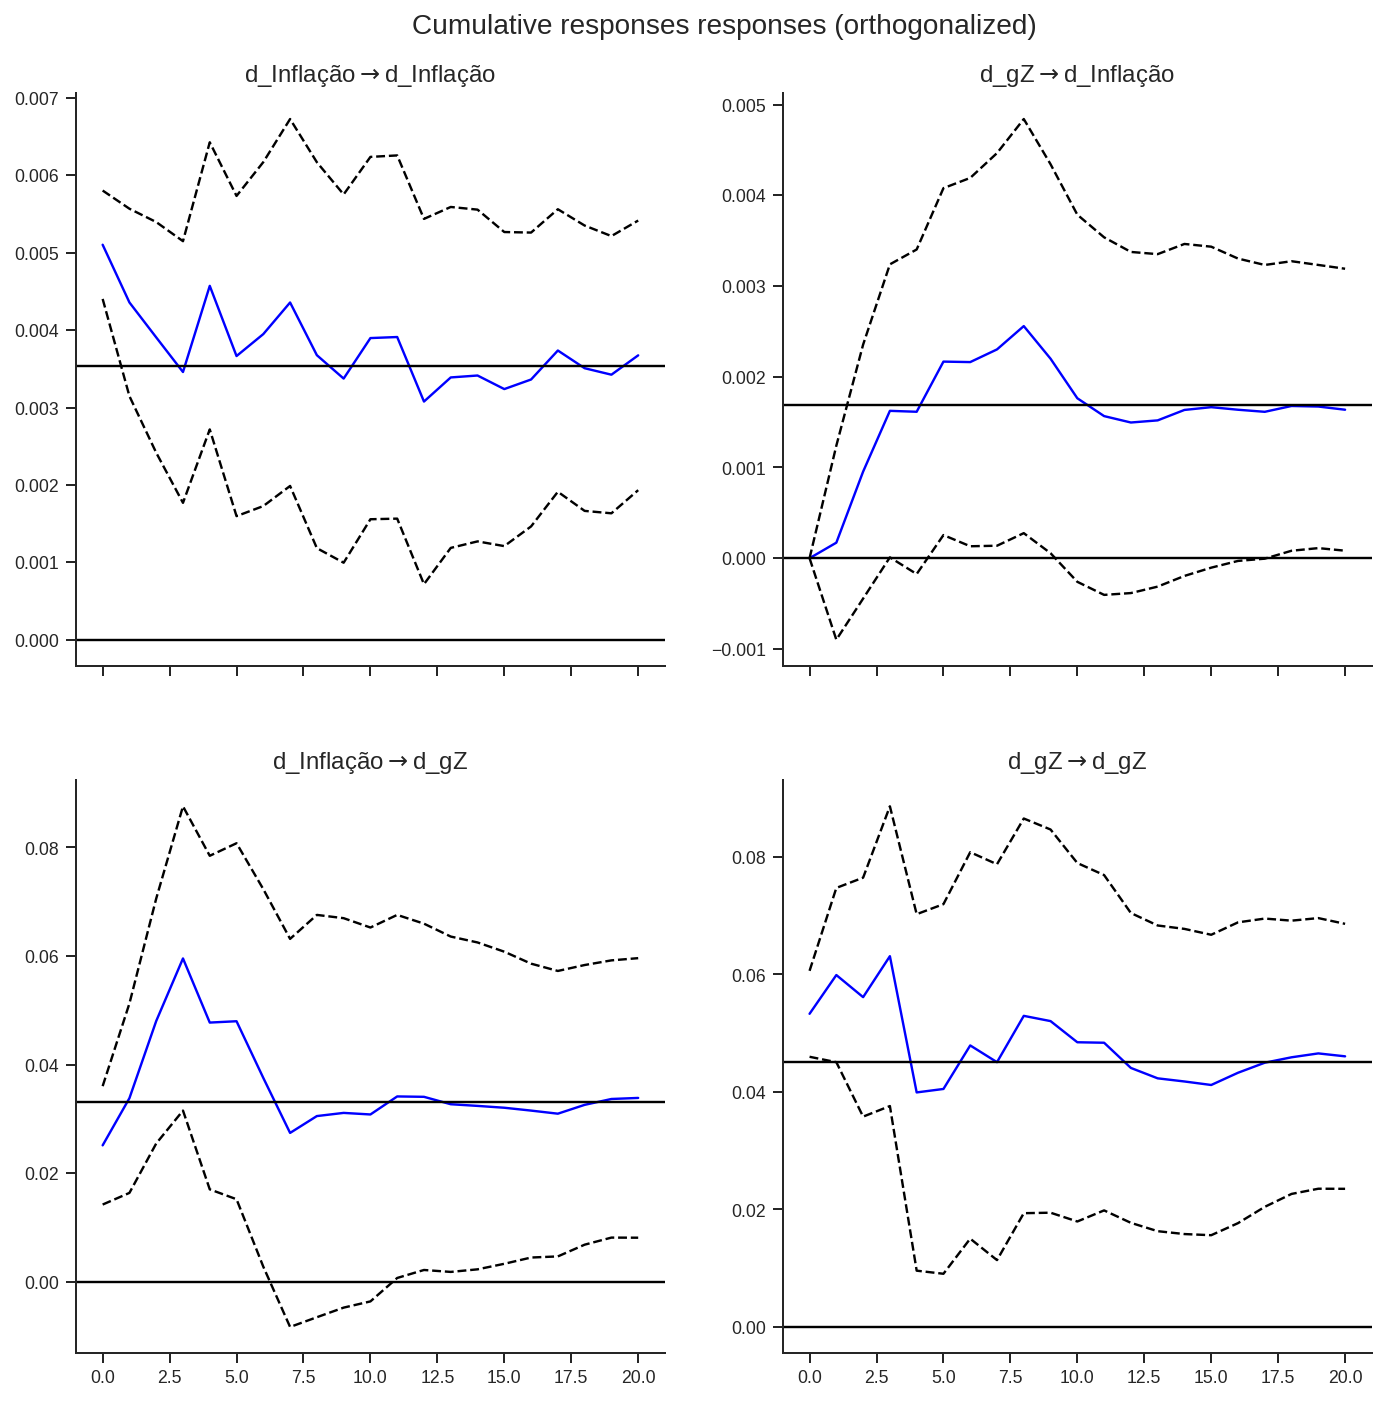

In [43]:
p = results.irf(20).plot_cum_effects(orth=True)
sns.despine()
plt.show()
p.savefig("./figs/Impulso_Cum.png", dpi = 300)

## Decomposição da variância

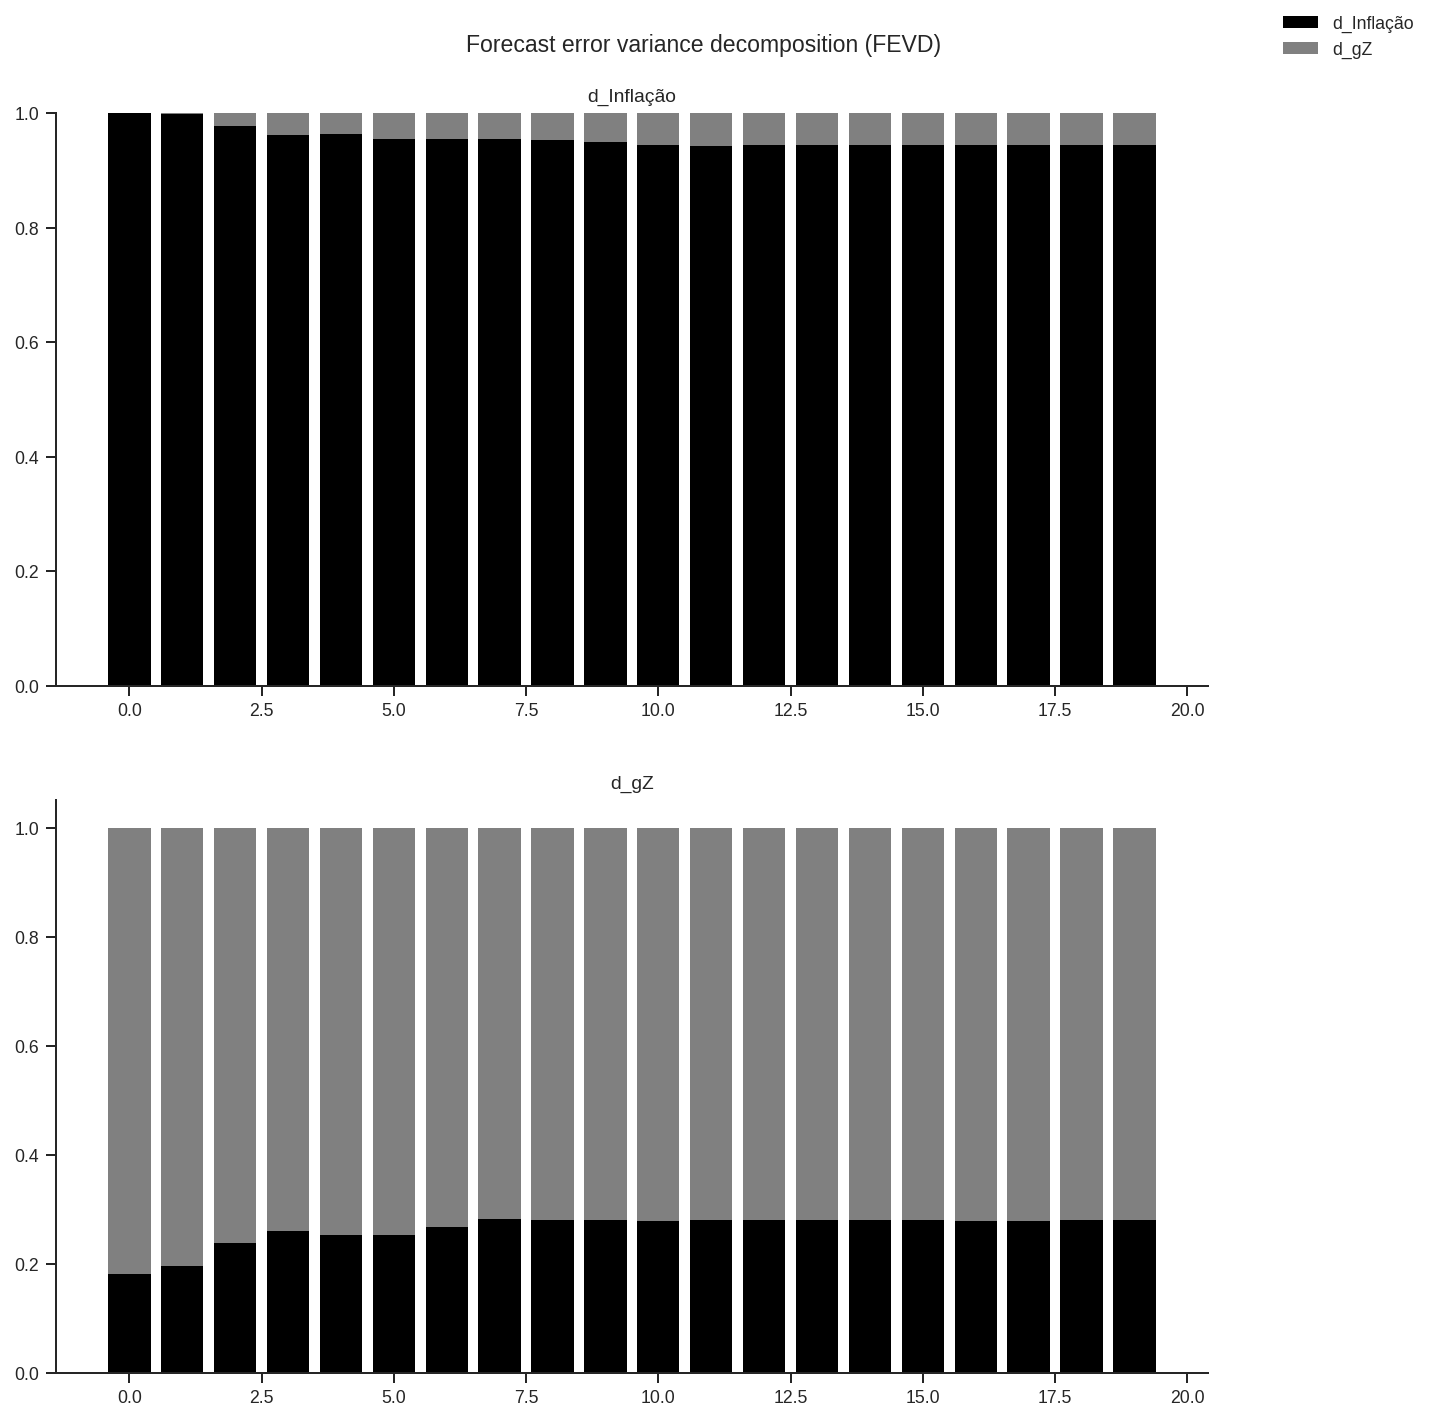

In [44]:
p = results.fevd(20).plot()
sns.despine()
plt.show()
p.savefig("./figs/DecompVar.png", dpi = 300)